Packages that might need installment (in comment according to Ron's instruction):

In [1]:
#!pip install IterativeImputer
#!pip install RFE
#!pip install scikit-optimize


First we want to import all the relevant libraries:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.experimental import enable_halving_search_cv
from sklearn.impute import IterativeImputer
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from skopt import gp_minimize
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import RobustScaler
import warnings
warnings.filterwarnings('ignore')

Next, we want to read our train data into a Pandas DataFrame and start analyizing it:

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
our_random_state = 4
# Display basic information about the dataset
print(train_data.info())
# Show summary statistics
print(train_data.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55462 entries, 0 to 55461
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   55462 non-null  int64  
 1   worked_in_the_past   53697 non-null  object 
 2   age_group            52922 non-null  object 
 3   disability           51781 non-null  object 
 4   is_dev               53372 non-null  object 
 5   education            52446 non-null  object 
 6   sex                  52234 non-null  object 
 7   mental_issues        53047 non-null  object 
 8   years_of_experience  52898 non-null  float64
 9   A                    53327 non-null  float64
 10  B                    51927 non-null  float64
 11  C                    52460 non-null  object 
 12  D                    52843 non-null  float64
 13  country              53443 non-null  object 
 14  prev_salary          52798 non-null  float64
 15  stack_experience     41420 non-null 

From this simple description, we can see that the features "A" and "B" have outliers, since in "A" the 75th percentile is 7.85, yet the maximum value is 55.49. <br>
Same goes for B: the 75th percentile is 12, yet the max value is 50. Those are clearly outliers, hence we would like to take a closer look at both of these features:

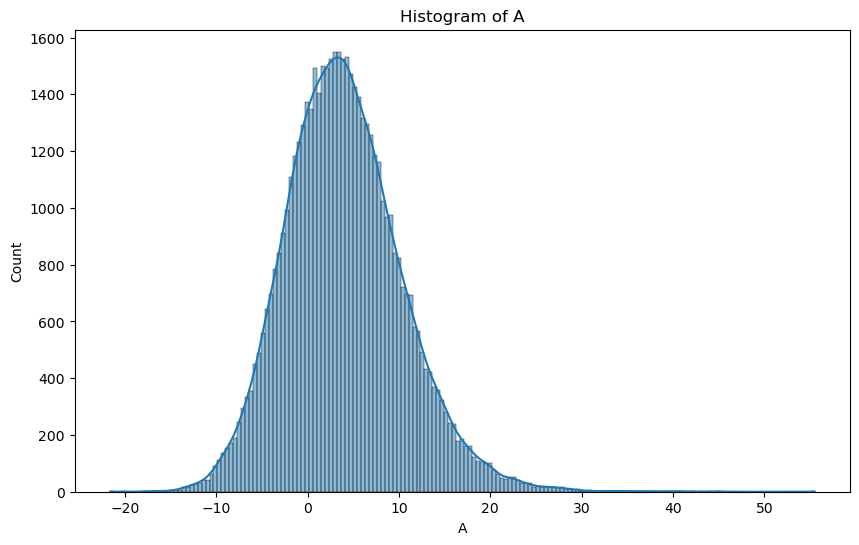

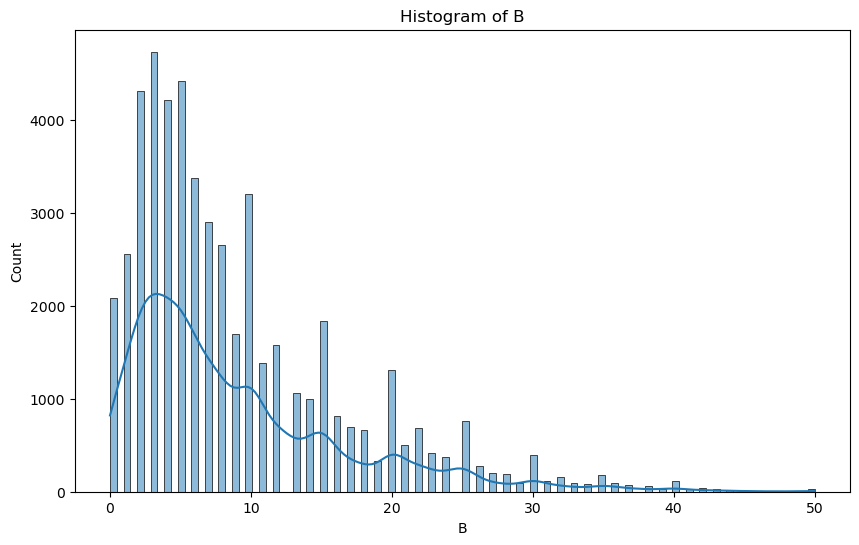

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(data = train_data, x = "A", kde = True)
plt.title("Histogram of A")
plt.show()
plt.figure(figsize=(10, 6))
sns.histplot(data = train_data, x = "B", kde = True)
plt.title("Histogram of B")
plt.show()

From the following histograms we can learn the feature A distributes normally, and according to the the .describe() we can see that there are a few outliers. <br>
We can see that in "B"'s histogram there is one clear outlier at 50, but since according to the .describe() its 75th percentile is 12 and the max value is 50, we decided to remove all the rows where B > 40.

We will visualize these features with Box Plot as well, to see if we can learn anything else:

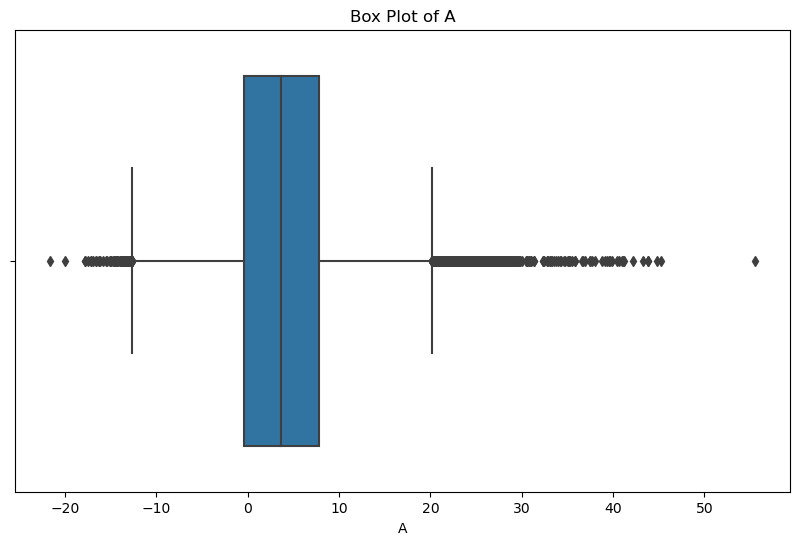

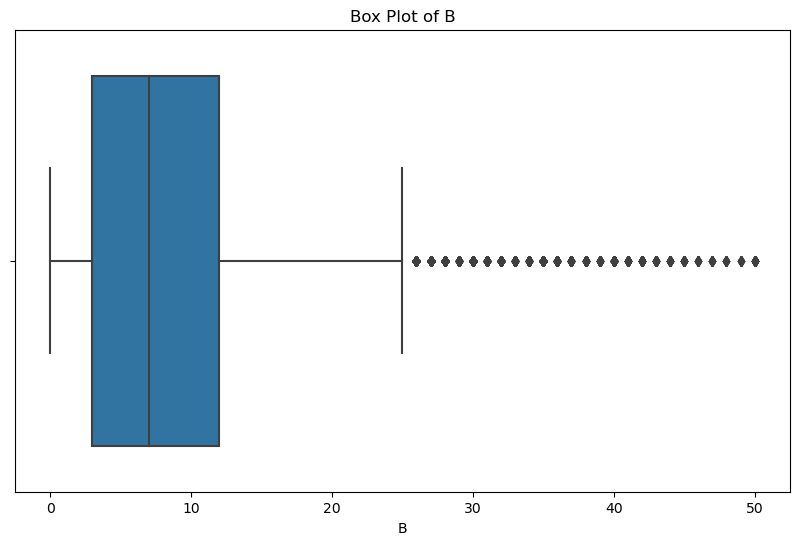

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(x = train_data ["A"])
plt.title("Box Plot of A")
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(x = train_data ["B"])
plt.title("Box Plot of B")
plt.show()

Box plot A shows clear outliers where the value of A is bigger than 30, and when its smaller than -16, hence we will remove it. <br>
Its hard to learn anything from box plot B because the data doesn't distribute normally, so we used the 75th percentile and the histogram as indicators to which values we should remove.

In [6]:
train_data = train_data.drop(train_data [train_data ["A"] > 30].index)
train_data = train_data.drop(train_data [train_data ["A"] < -16].index)
train_data = train_data.drop(train_data [train_data ["B"] > 40].index)
#Ensure the values were indeed deleted:
print(train_data.describe())
print(train_data.info())

                 ID  years_of_experience             A             B  \
count  55198.000000         52647.000000  53072.000000  51667.000000   
mean   36692.110076            14.105970      3.971726      8.950181   
std    21199.809524             9.209181      6.293551      7.682352   
min        0.000000             0.000000    -15.822203      0.000000   
25%    18379.250000             7.000000     -0.363737      3.000000   
50%    36668.500000            12.000000      3.598184      7.000000   
75%    55013.750000            20.000000      7.832358     12.000000   
max    73461.000000            50.000000     29.980608     40.000000   

                  D    prev_salary         label  
count  52592.000000   52555.000000  55198.000000  
mean     179.581124   67658.756370      0.536940  
std        1.094193   49506.461991      0.498638  
min      175.077992       1.000000      0.000000  
25%      178.844676   28794.000000      0.000000  
50%      179.584913   57588.000000      1.000

By eliminating these outliers, we chopped off about 250 entries, which isn't too bad becasue its a small number compared to 55000 + entires.

We will take a closer look now at years_of_experience and prev_salary:

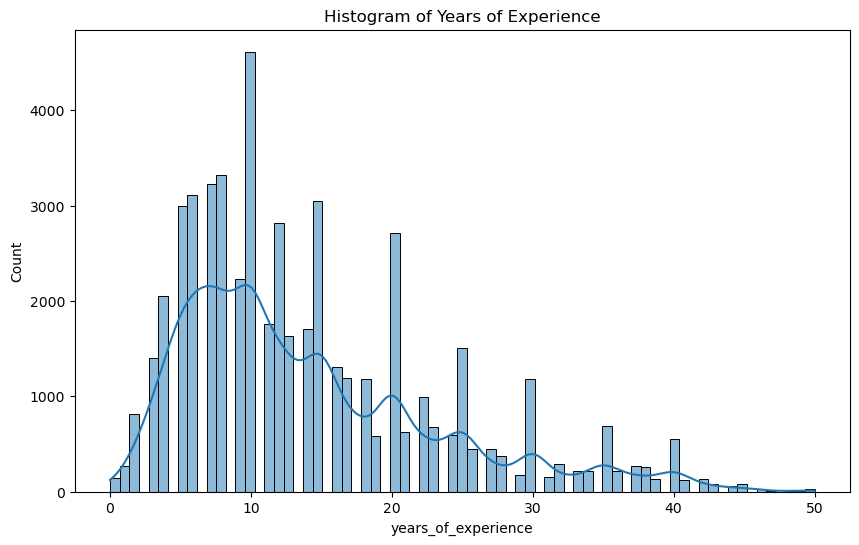

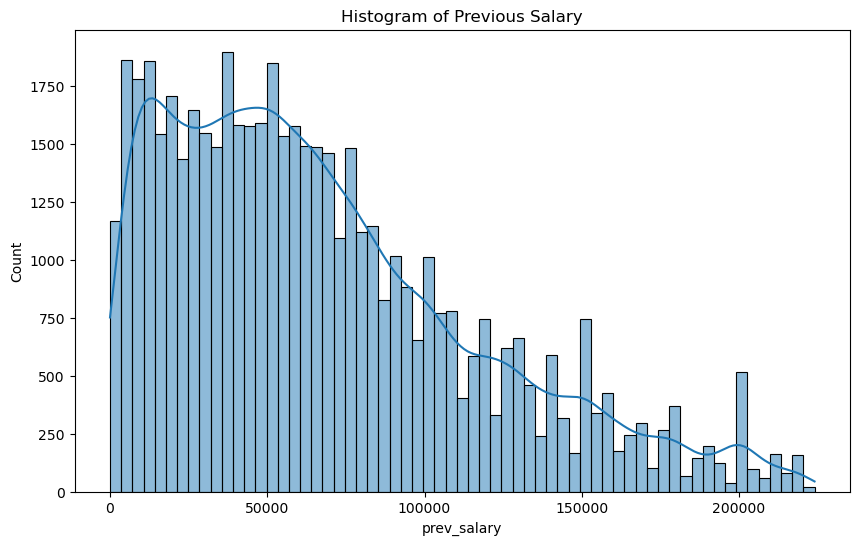

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(data = train_data, x = "years_of_experience", kde = True)
plt.title("Histogram of Years of Experience")
plt.show()
plt.figure(figsize=(10, 6))
sns.histplot(data = train_data, x = "prev_salary", kde = True)
plt.title("Histogram of Previous Salary")
plt.show()

From the Years of Experience histogram we don't see any outliers coming out, and according to the max year of experience (50) it also makes sense that there is none. <br>
However from the Previous Salary histogram we can clearly see that there is way too many people who get close to 0 (relatively) salary yearly. <br>
Those are clearly outliers and we decided to remove them, since keeping them and changing their values will confuse our models because there is a lot of them.

And the Box Plots:

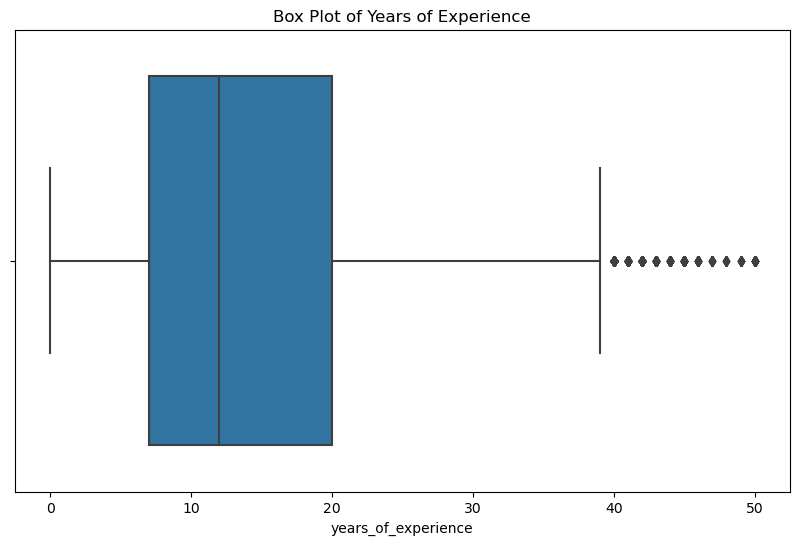

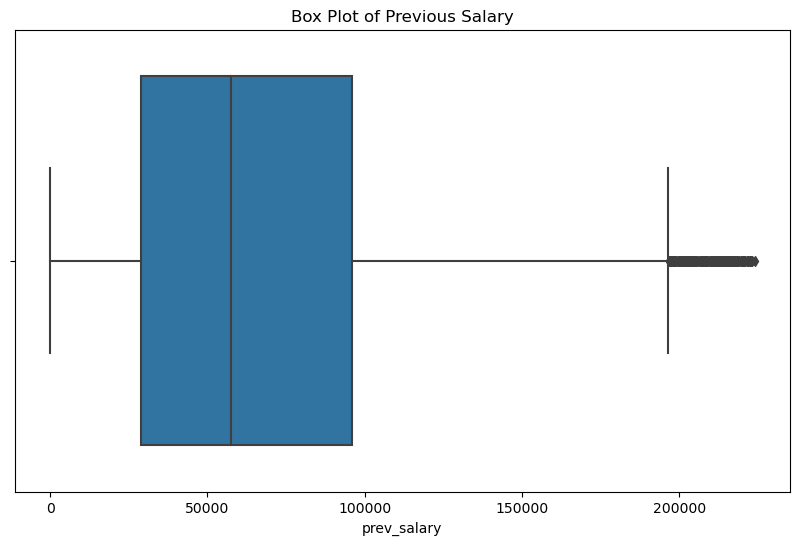

In [8]:
plt.figure(figsize=(10, 6))
sns.boxplot(x = train_data ["years_of_experience"])
plt.title("Box Plot of Years of Experience")
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(x = train_data ["prev_salary"])
plt.title("Box Plot of Previous Salary")
plt.show()

Its hard to see any outliers in the Previous Salary box plot and that is probably because the feature doesn't distribute normally. <br>
So we used the histogram and the info from the web to see what salaries aren't valid for High Tech jobs around the world. <br>
We came to the conclusion that 50 years of experience isn't necessarily an outlier. There are veterans in the industry after all.

Since we assume that the salary that is given in the data is yearly salary in dollars, it doesn't make sense that someone would get less than $5000 a year for a job in high tech, even in the poorest countires. <br>
We did an internet search for the average high tech worker’s salary by country to find that the lowest annual salary for someone in a High Tech position is $7,225 USD. In order to make sure that we don’t lose too much data we set the lower bound to $5000 USD. Any amount below the lower bound would be considered an outlier and removed.


In [9]:
train_data = train_data.drop(train_data [train_data ["prev_salary"] < 5000].index) #train data with data according to the internet
len(train_data)

53371

We will make a histogram that showcases how many applicants were accepted from each country and how many were denied, <br>
in hopes of finding any interesting insights or ways how to use the data of the countries.

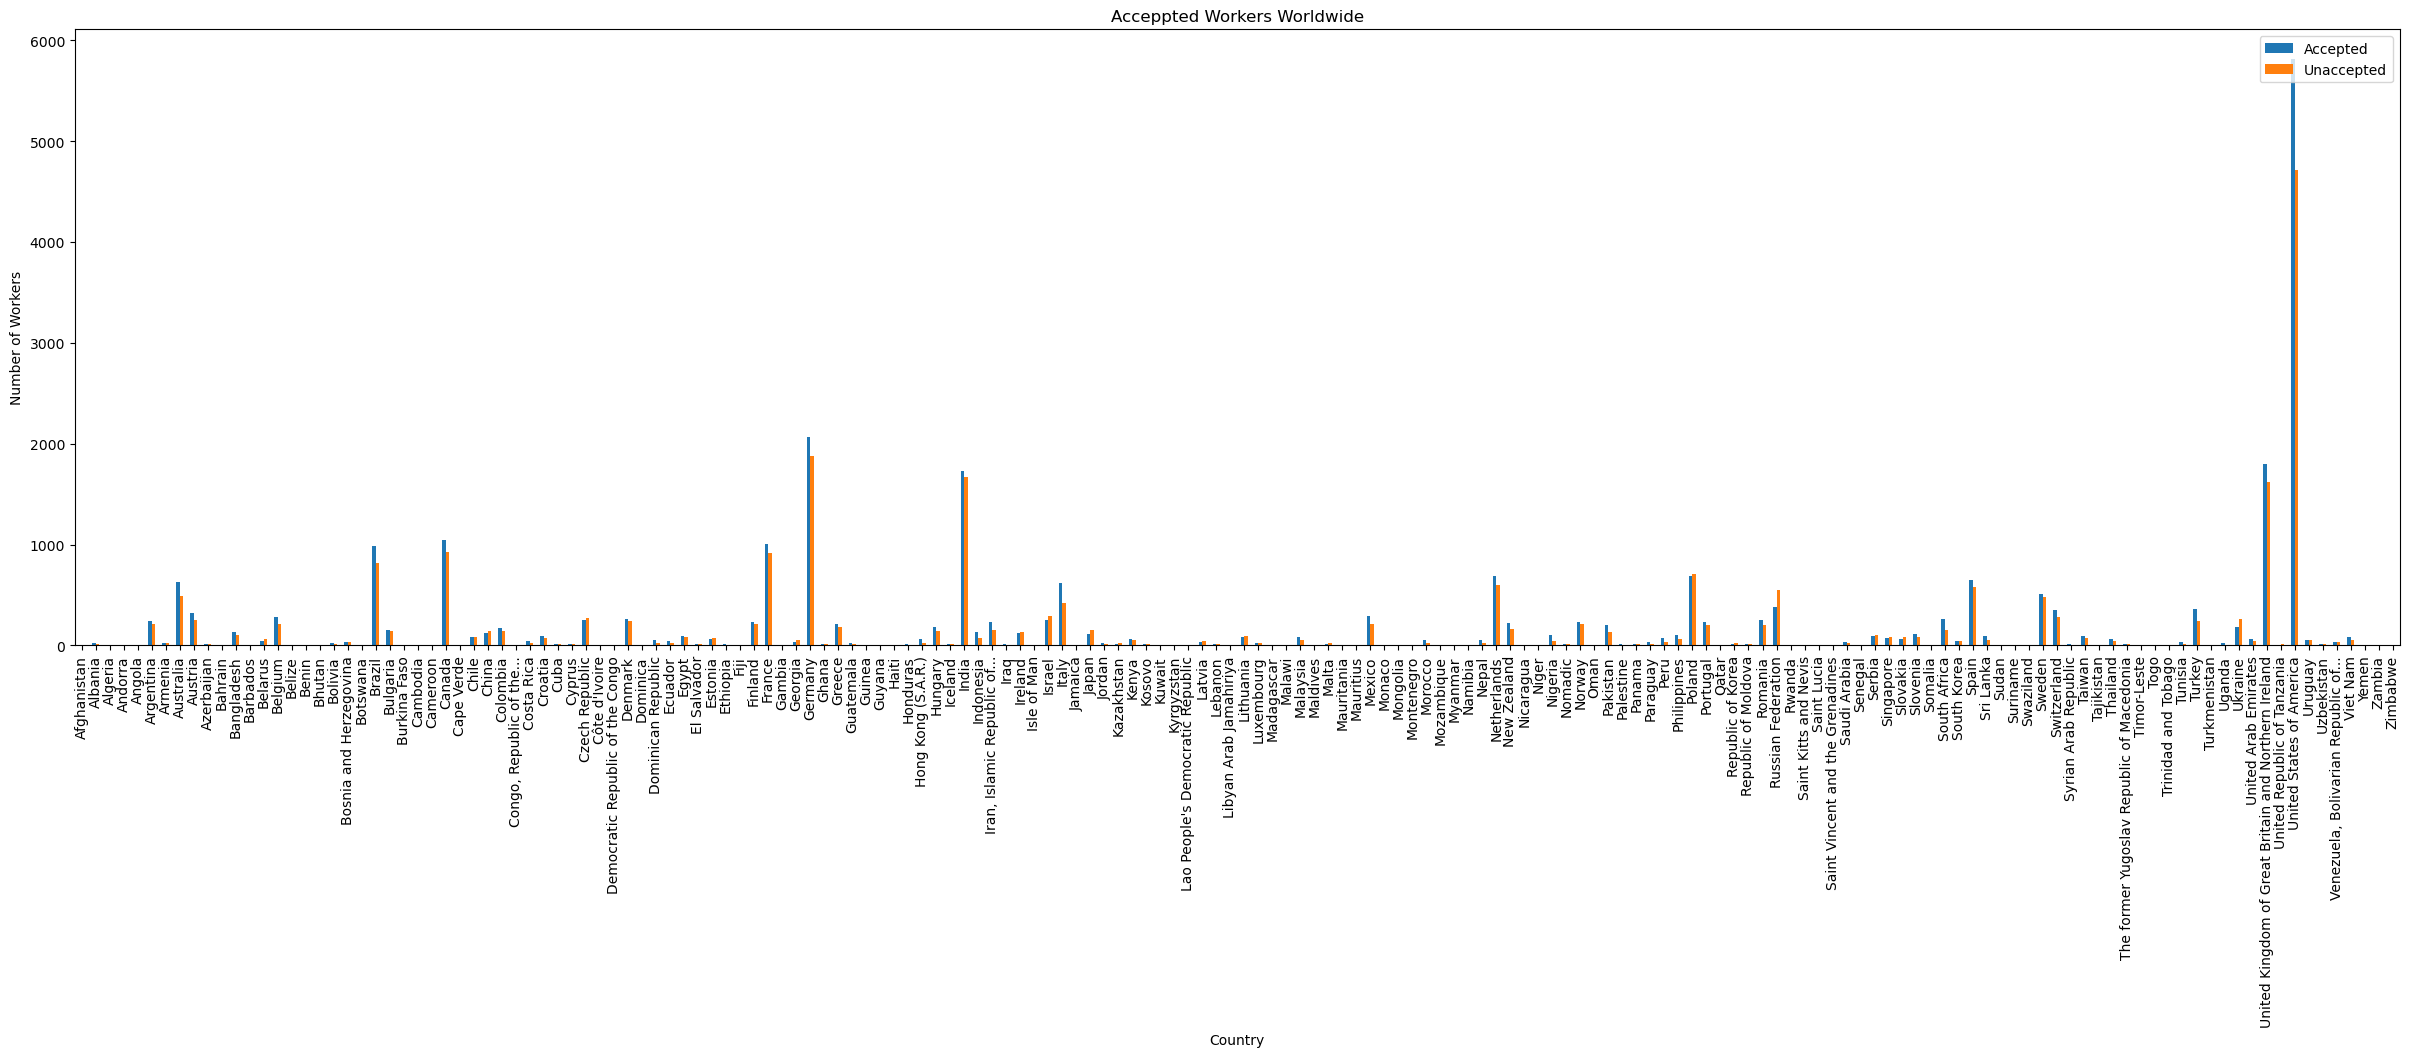

In [10]:
all_countries = train_data['country'].value_counts()
all_countries_index = all_countries.index
label_1_counts = train_data [train_data ['country'].isin(all_countries_index) & (train_data ['label'] == 1)]['country'].value_counts()
label_0_counts = train_data [train_data ['country'].isin(all_countries_index) & (train_data ['label'] == 0)]['country'].value_counts()
# Combine counts into a single DataFrame for plotting
counts_df = pd.DataFrame({'Accepted': label_1_counts, 'Unaccepted': label_0_counts})
fig, ax = plt.subplots(figsize= (30,8))
counts_df.plot(kind='bar', ax=ax)
plt.xlabel('Country')
plt.ylabel('Number of Workers')
plt.title('Acceppted Workers Worldwide')
plt.legend(loc='upper right')
plt.show()

From looking at this histogram, we can see that other than a few outliers, the proportions between people who got the job and people who didn't remain the same per countries (to the naked eye). There is one obvious outlier: the USA. USA has a considerably larger high-tech market than other countries,  meaning that citizens of the United States are more likely to be accepted to work in high tech simply because there’s a larger population of people applying for these jobs. So, we decided to fill the NaN values in country with USA, since the majority of the work force in the database comes from there.

The following information about the categorial data helped us decide how to handle the NaN values:

In [11]:
print(train_data.isna().sum())
print()
print(train_data ["is_dev"].value_counts())
print()
print(train_data ["disability"].value_counts())
print()
print(train_data ["sex"].value_counts())
print()
print(train_data ["mental_issues"].value_counts())

ID                         0
worked_in_the_past      1695
age_group               2441
disability              3554
is_dev                  2011
education               2921
sex                     3100
mental_issues           2320
years_of_experience     2470
A                       2052
B                       3407
C                       2894
D                       2521
country                 1948
prev_salary             2643
stack_experience       13518
label                      0
dtype: int64

developer        47220
non-developer     4140
Name: is_dev, dtype: int64

No     48412
Yes     1405
Name: disability, dtype: int64

Male      46935
Female     2394
Other       942
Name: sex, dtype: int64

No     39484
Yes    11567
Name: mental_issues, dtype: int64


# Dealing with NaN Values and Categorial Features:

We will start with filling the NaNs in worked in the past first: <br>
We made the assumption that someone who has work experience from past jobs would have reported it, therefore all NaNs in “worked_in_the_past” were turned into “F” to signify that they do not in fact have previous work experience.

In [12]:
train_data_copy = train_data.copy()
train_data_copy = train_data_copy.reset_index(drop = True)
train_data_copy ["worked_in_the_past"].fillna("F", inplace= True)
train_data_copy ["worked_in_the_past"] = train_data_copy ["worked_in_the_past"].map({"T": 1, "F": 0})
print(train_data_copy.isna().sum()) #Validata that indeed all NaN values were removed

ID                         0
worked_in_the_past         0
age_group               2441
disability              3554
is_dev                  2011
education               2921
sex                     3100
mental_issues           2320
years_of_experience     2470
A                       2052
B                       3407
C                       2894
D                       2521
country                 1948
prev_salary             2643
stack_experience       13518
label                      0
dtype: int64


Fill the NaN values for years of experience: <br>
We replaced all NaN values with the calculated median of “years_of_experience”. <br>
We originally thought to use the mean, but there was a greater risk of losing a lot of information by doing so. Also, had we missed any outliers, they would have impacted our mean significantly.

In [13]:
train_data_copy ["years_of_experience"].fillna(train_data_copy ["years_of_experience"].median(), inplace= True)
print(train_data_copy.isna().sum()) #Validata that indeed all NaN values were removed

ID                         0
worked_in_the_past         0
age_group               2441
disability              3554
is_dev                  2011
education               2921
sex                     3100
mental_issues           2320
years_of_experience        0
A                       2052
B                       3407
C                       2894
D                       2521
country                 1948
prev_salary             2643
stack_experience       13518
label                      0
dtype: int64


Fill the NaN values for age group: <br>
To fill the NaNs in “age_group” we took the number 18 as a base and then added that individual’s “years_of_experience”. <br>
If the sum was under 35 then the NaN value would be replaced with “young”, otherwise it would be replaced with “old”. 

In [14]:
age_check = train_data_copy ["years_of_experience"] + 18
age_check = (age_check <= 35).map({True: 'young', False: 'old'})
train_data_copy ["age_group"].fillna(age_check, inplace= True)
print(train_data_copy.isna().sum()) #Validata that indeed all NaN values were removed

ID                         0
worked_in_the_past         0
age_group                  0
disability              3554
is_dev                  2011
education               2921
sex                     3100
mental_issues           2320
years_of_experience        0
A                       2052
B                       3407
C                       2894
D                       2521
country                 1948
prev_salary             2643
stack_experience       13518
label                      0
dtype: int64


Fill the NaN values for is dev and convert the categorial feature into numerical: <br>
We originally made an assumption that all individuals applying for jobs in High Tech are applying for a position in coding.<br>
We made this assumption because of the “Stack Experience” feature, in order to erase all the “NaN” values. After which we remembered the existence of the “is_dev” feature, which was problematic for our previous assumption.<br> 
To clarify, it would make sense for an individual who is not applying for a job in coding to not know how to code hence, there is no legitimate reason to remove that part of the data. <br>
In the end, we chose to fill out the NaN values in “is_dev” according to the existing ratio of developers to non-developers in the data.

In [15]:
dev_count = train_data_copy ["is_dev"]
dev_count = dev_count.map({"developer": 1, "non-developer":0})
proba_dev = dev_count.sum() / dev_count.count() #Calculate the probability of being a developer in our data
print(f"The probability of being a developer: {proba_dev}")
np.random.seed(4)
dev_count_random = pd.Series(np.random.random(len(dev_count))) #len(dev_cout) How many random variables I want
dev_count_random = (dev_count_random <= proba_dev).map({True: 1, False: 0}) #If we didn't pass the threshold (the calculated probability above) then its a developer. else: None developer
train_data_copy ["is_dev"] = train_data_copy ["is_dev"].map({"developer": 1, "non-developer":0})
train_data_copy ["is_dev"].fillna(dev_count_random, inplace= True)
print(train_data_copy.isna().sum()) #Validata that indeed all NaN values were removed
train_data_copy ["is_dev"].value_counts()
train_data_copy.head(50)

The probability of being a developer: 0.919392523364486
ID                         0
worked_in_the_past         0
age_group                  0
disability              3554
is_dev                     0
education               2921
sex                     3100
mental_issues           2320
years_of_experience        0
A                       2052
B                       3407
C                       2894
D                       2521
country                 1948
prev_salary             2643
stack_experience       13518
label                      0
dtype: int64


,ID,worked_in_the_past,age_group,disability,is_dev,education,sex,mental_issues,years_of_experience,A,B,C,D,country,prev_salary,stack_experience,label
0,65168,1,young,No,1.0,NaN,Male,No,13.0,-1.093080,1.0,aa,180.984266,NaN,67104.0,Bash/Shell;Java;JavaScript;PowerShell;Python;T...,1
1,38314,1,young,No,0.0,other,Male,Yes,7.0,5.444533,7.0,rhz,180.677533,United States of America,101000.0,Bash/Shell;JavaScript;PowerShell;Python;Docker...,0
2,5209,1,old,No,1.0,other,Male,Yes,25.0,1.727255,15.0,aa,177.746162,United States of America,70000.0,Bash/Shell;HTML/CSS;Java;JavaScript;PHP;SQL;Gi...,0
3,54165,1,young,NaN,1.0,other,Male,No,10.0,17.804302,7.0,aa,176.952584,Spain,40956.0,C#;Dart;Delphi;Kotlin;SQL;VBA;Docker;Unity 3D;...,0
4,42213,1,young,No,1.0,BA/BSc,Male,No,12.0,-8.679091,4.0,hr,179.393259,Canada,101509.0,Assembly;Bash/Shell;C++;PowerShell;Python;Rust,0
5,10932,1,old,No,1.0,other,Male,No,40.0,-1.630744,25.0,rhz,179.847985,Australia,106895.0,C#;F#;JavaScript;Node.js;SQL;TypeScript;Ansibl...,1
6,11349,1,young,NaN,0.0,MA/MSc,Female,No,7.0,-4.331449,2.0,rhz,NaN,France,37834.0,NaN,0
7,48954,1,old,No,1.0,BA/BSc,Male,No,46.0,5.112595,25.0,aa,179.988380,South Africa,50064.0,Clojure;HTML/CSS;JavaScript;Ansible;Docker;Hom...,0
8,62254,1,young,No,1.0,High school,Female,Yes,41.0,-8.563864,NaN,rhz,178.526025,NaN,17916.0,NaN,0
9,52371,1,old,NaN,1.0,other,Male,Yes,34.0,14.469466,19.0,aa,179.575730,Germany,NaN,NaN,0


Fill the NaN values for disability and convert the categorial feature into numerical: <br>
In order to fill the NaN values in the “disability” column, we first calculated the ratio of “yes”s to “no”s in the column data. <br> 
After which we used a function to randomly replace the NaN values in the column with either “yes” or “no” in accordance with the calculated probability.  

In [16]:
dis_count = train_data_copy ["disability"]
dis_count = dis_count.map({"Yes": 1, "No":0})
proba_dis = dis_count.sum() / dis_count.count() #Calculate the probability of being disable in our data
print(f"The probability of being disable: {proba_dis}")
np.random.seed(4)
dis_count_random = pd.Series(np.random.random(len(dis_count)))
dis_count_random = (dis_count_random <= proba_dis).map({True: 1, False: 0}) #If we didn't pass the threshold (the calculated probability above) then the individual is disable. else: not disable
train_data_copy ["disability"] = train_data_copy ["disability"].map({"Yes": 1, "No": 0})
train_data_copy ["disability"].fillna(dis_count_random, inplace= True)
print(train_data_copy.isna().sum()) #Validata that indeed all NaN values were removed
print(train_data_copy ["disability"].value_counts())

The probability of being disable: 0.028203223799104723
ID                         0
worked_in_the_past         0
age_group                  0
disability                 0
is_dev                     0
education               2921
sex                     3100
mental_issues           2320
years_of_experience        0
A                       2052
B                       3407
C                       2894
D                       2521
country                 1948
prev_salary             2643
stack_experience       13518
label                      0
dtype: int64
0.0    51872
1.0     1499
Name: disability, dtype: int64


Fill the NaN values for education: <br>
Since the “education” column is divided into categories, we elected to replace every NaN value with “other”.

In [17]:
train_data_copy ["education"].fillna("other", inplace= True)
print(train_data_copy.isna().sum()) #Validata that indeed all NaN values were removed
train_data_copy ["education"].value_counts()

ID                         0
worked_in_the_past         0
age_group                  0
disability                 0
is_dev                     0
education                  0
sex                     3100
mental_issues           2320
years_of_experience        0
A                       2052
B                       3407
C                       2894
D                       2521
country                 1948
prev_salary             2643
stack_experience       13518
label                      0
dtype: int64


BA/BSc         25499
MA/MSc         13182
other          10356
High school     2505
Phd             1829
Name: education, dtype: int64

Fill the NaN values for sex: <br>
Similar to how we dealt with the missing values in “disability”, we calculated a ratio between the three possible options: “Male”, “Female”, and “Other”. <br>
The NaN values would then be replaced by these options in accordance with their calculated likelihood.

In [18]:
sex_count = train_data_copy ["sex"].value_counts()
num_of_other = sex_count.loc["Other"]
num_of_female = sex_count.loc["Female"]
num_of_male = sex_count.loc["Male"]
proba_other = num_of_other / train_data_copy ["sex"].count()
proba_female = num_of_female / train_data_copy ["sex"].count()
proba_male = num_of_male / train_data_copy ["sex"].count()
np.random.seed(4)
sex_count_random = pd.Series(np.random.random(len(train_data_copy)), index = train_data_copy.index)
categories = ["Other", "Female", "Male"]
bins = [0, proba_other, proba_female, 1]
sex_count_random = pd.cut(sex_count_random, bins=bins, labels=categories)
train_data_copy ["sex"].fillna(sex_count_random, inplace= True)
print(train_data_copy.isna().sum()) #Validata that indeed all NaN values were removed
train_data_copy ["sex"].value_counts()
print(train_data_copy.index)
print(sex_count_random.index)

ID                         0
worked_in_the_past         0
age_group                  0
disability                 0
is_dev                     0
education                  0
sex                        0
mental_issues           2320
years_of_experience        0
A                       2052
B                       3407
C                       2894
D                       2521
country                 1948
prev_salary             2643
stack_experience       13518
label                      0
dtype: int64
RangeIndex(start=0, stop=53371, step=1)
RangeIndex(start=0, stop=53371, step=1)


Fill the NaN values for mental_issues and convert the categorial feature into numerical: <br>
In the same manner as  how we dealt with the missing values in “disability”,  we first calculated the ratio of “yes”s to “no”s in the column data. <br>
After which we used a function to randomly replace the NaN values in the column with either “yes” or “no” in accordance with the calculated probability.

In [19]:
mi_count = train_data_copy ["mental_issues"]
mi_count = mi_count.map({"Yes": 1, "No":0})
proba_mi = mi_count.sum() / mi_count.count() #Calculate the probability of being mentally ill in our data
print(f"The probability of being mentally ill: {proba_mi}")
mi_count_random = pd.Series(np.random.random(len(mi_count)))
mi_count_random = (mi_count_random <= proba_mi).map({True: 1, False: 0}) #If we didn't pass the threshold (the calculated probability above) then the individual is disable. else: not disable
train_data_copy ["mental_issues"] = train_data_copy ["mental_issues"].map({"Yes": 1, "No":0})
train_data_copy ["mental_issues"].fillna(mi_count_random, inplace= True)
print(train_data_copy.isna().sum())

The probability of being mentally ill: 0.22657734422440304
ID                         0
worked_in_the_past         0
age_group                  0
disability                 0
is_dev                     0
education                  0
sex                        0
mental_issues              0
years_of_experience        0
A                       2052
B                       3407
C                       2894
D                       2521
country                 1948
prev_salary             2643
stack_experience       13518
label                      0
dtype: int64


Fill the NaN values in A, B, D: <br>
For the features “A”, “B” and “D”, we replaced the NaN values with each column’s respective median.

In [20]:
train_data_copy ["A"].fillna(train_data_copy ["A"].median(), inplace= True)
train_data_copy ["B"].fillna(train_data_copy ["B"].median(), inplace= True)
train_data_copy ["D"].fillna(train_data_copy ["D"].median(), inplace= True)
print(train_data_copy.isna().sum())

ID                         0
worked_in_the_past         0
age_group                  0
disability                 0
is_dev                     0
education                  0
sex                        0
mental_issues              0
years_of_experience        0
A                          0
B                          0
C                       2894
D                          0
country                 1948
prev_salary             2643
stack_experience       13518
label                      0
dtype: int64


Fill NaN values for C: <br>
For “C” ‘s  NaN values, we initially thought to ignore them because we couldn’t decide on a method that wouldn’t result in a massive loss of information. <br>
The feature “C” appears to be categorical in nature; we filled the NaN values with “aa” since it was the most commonly occurring value.

In [21]:
train_data_copy ["C"].value_counts()
train_data_copy ["C"].fillna("aa", inplace = True)
print(train_data_copy.isna().sum())

ID                         0
worked_in_the_past         0
age_group                  0
disability                 0
is_dev                     0
education                  0
sex                        0
mental_issues              0
years_of_experience        0
A                          0
B                          0
C                          0
D                          0
country                 1948
prev_salary             2643
stack_experience       13518
label                      0
dtype: int64


Fill the NaN values for countries: <br>
Since this feature is a categorical type with many variables, it took us a while to figure out how to deal with its missing variables. <br>
One of the ideas we had was to create a Dummy Variable called "United States” that would receive “1” if the individual was a US citizen and “0” if not. <br>
This idea came about because while visualizing the data, Natanel noticed there was a significantly larger amount of individuals being accepted to work in the States. <br>
This idea was shot down because while it is true that a larger population of individuals were hired to work in the United States in comparison to the rest of the world, simultaneously a population of substantial size was also being rejected.<br>The decided solution ended up being to fill the NaN values in “country” with “United States” because that is where the vast majority of individuals in the data were from. 

In [22]:
train_data_copy ["country"].fillna("United States of America", inplace= True)
print(train_data_copy.isna().sum())

ID                         0
worked_in_the_past         0
age_group                  0
disability                 0
is_dev                     0
education                  0
sex                        0
mental_issues              0
years_of_experience        0
A                          0
B                          0
C                          0
D                          0
country                    0
prev_salary             2643
stack_experience       13518
label                      0
dtype: int64


# Multi Categorial Features

In order to deal with categorical variables we used the command get_dummies from the pandas library on each feature that is categorical (age_group, education, “C”, and sex). <br>
After which we used the concat command to add the dummy variables to the data as new features. We did the same for test data as well.

In [23]:
age_dummies = pd.get_dummies(train_data_copy["age_group"])
educ_dummies = pd.get_dummies(train_data_copy["education"])
sex_dummies = pd.get_dummies(train_data_copy["sex"])
c_dummies = pd.get_dummies(train_data_copy ["C"])
train_data_copy = pd.concat([train_data_copy, age_dummies, educ_dummies, sex_dummies, c_dummies], axis = 1)
train_data_copy.head(50)

,ID,worked_in_the_past,age_group,disability,is_dev,education,sex,mental_issues,years_of_experience,A,...,Female,Male,Other,aa,br,ca,hr,mn,rhz,ww
0,65168,1,young,0.0,1.0,other,Male,0.0,13.0,-1.093080,...,0,1,0,1,0,0,0,0,0,0
1,38314,1,young,0.0,0.0,other,Male,1.0,7.0,5.444533,...,0,1,0,0,0,0,0,0,1,0
2,5209,1,old,0.0,1.0,other,Male,1.0,25.0,1.727255,...,0,1,0,1,0,0,0,0,0,0
3,54165,1,young,0.0,1.0,other,Male,0.0,10.0,17.804302,...,0,1,0,1,0,0,0,0,0,0
4,42213,1,young,0.0,1.0,BA/BSc,Male,0.0,12.0,-8.679091,...,0,1,0,0,0,0,1,0,0,0
5,10932,1,old,0.0,1.0,other,Male,0.0,40.0,-1.630744,...,0,1,0,0,0,0,0,0,1,0
6,11349,1,young,0.0,0.0,MA/MSc,Female,0.0,7.0,-4.331449,...,1,0,0,0,0,0,0,0,1,0
7,48954,1,old,0.0,1.0,BA/BSc,Male,0.0,46.0,5.112595,...,0,1,0,1,0,0,0,0,0,0
8,62254,1,young,0.0,1.0,High school,Female,1.0,41.0,-8.563864,...,1,0,0,0,0,0,0,0,1,0
9,52371,1,old,0.0,1.0,other,Male,1.0,34.0,14.469466,...,0,1,0,1,0,0,0,0,0,0


Since we added columns to the train data, we should do the same for test data:

In [24]:
educ_dummies = pd.get_dummies(test_data["education"]) 
age_dummies = pd.get_dummies(test_data["age_group"])
sex_dummies = pd.get_dummies(test_data["sex"])
c_dummies = pd.get_dummies(test_data ["C"])
test_data = pd.concat([test_data, age_dummies, educ_dummies, sex_dummies, c_dummies], axis = 1)
test_data.head(50)

,ID,worked_in_the_past,age_group,disability,is_dev,education,sex,mental_issues,years_of_experience,A,...,Female,Male,Other,aa,br,ca,hr,mn,rhz,ww
0,48786,F,young,No,developer,BA/BSc,Male,No,5.0,9.731222,...,0,1,0,1,0,0,0,0,0,0
1,53074,T,old,No,non-developer,other,Male,No,5.0,-2.482247,...,0,1,0,1,0,0,0,0,0,0
2,11758,T,NaN,No,developer,NaN,Male,No,20.0,7.969130,...,0,1,0,0,0,0,0,0,0,0
3,49289,T,old,NaN,developer,BA/BSc,Male,No,20.0,-3.644784,...,0,1,0,0,0,0,0,1,0,0
4,56787,F,old,No,developer,other,Male,No,40.0,-5.277558,...,0,1,0,1,0,0,0,0,0,0
5,27135,T,young,No,NaN,other,Male,No,5.0,-1.225907,...,0,1,0,1,0,0,0,0,0,0
6,1222,T,young,No,developer,BA/BSc,Male,No,6.0,1.930038,...,0,1,0,0,0,0,0,0,0,1
7,45631,F,young,No,developer,MA/MSc,Male,Yes,15.0,13.836920,...,0,1,0,1,0,0,0,0,0,0
8,29686,T,old,No,developer,Phd,Male,No,30.0,13.112047,...,0,1,0,0,0,0,1,0,0,0
9,71663,T,young,No,developer,BA/BSc,Male,No,16.0,-1.375487,...,0,1,0,0,0,1,0,0,0,0


# Adding Our Own Features and Dealing with prev_salary 

In order to deal with the categorical features, we created new columns in the data with dummy variables of the categorical features. <br>
We also added a feature “is_top_ten”, a dummy variable that would receive a ”1” if the individual was from a country in the top ten of countries with the most applicants for high-tech positions. <br>
In order to incorporate the “stack_experience” feature into the models more effectively, we made a new feature called “stack_in_num” which recorded the number of programming languages an individual knows. <br>

While trying to figure out how to replace the NaN values in “stack_experience” we made a function that would count the number of semicolons used to separate each programming language in “stack_experience”. The result would be saved in a new column by the name of “stack_in_num”, which served as a representation of the number of programming languages that an individual knows.  <br>
We will fill the NaN values of these columns using IterativeImputer, since we believe that the amount of programming languages an applicant knows correlates with his other features.

In [25]:
def count_semicolons(text):
  if type(text) == str:
    return text.count(';')
  else:
    return None
train_data_copy ["stack_in_num"] = train_data_copy ["stack_experience"].astype(str)
train_data_copy ["stack_in_num"] = train_data_copy ["stack_in_num"].replace("nan", np.nan)
stack_in_num = train_data_copy['stack_in_num'].apply(count_semicolons)
train_data_copy ["stack_in_num"] = stack_in_num
# Doing the same thing for the test data.
test_data ["stack_in_num"] = test_data ["stack_experience"].astype(str)
test_data ["stack_in_num"] = test_data ["stack_in_num"].replace("nan", np.nan)
stack_in_num = test_data['stack_in_num'].apply(count_semicolons)
test_data ["stack_in_num"] = stack_in_num
print(train_data_copy.isna().sum())

ID                         0
worked_in_the_past         0
age_group                  0
disability                 0
is_dev                     0
education                  0
sex                        0
mental_issues              0
years_of_experience        0
A                          0
B                          0
C                          0
D                          0
country                    0
prev_salary             2643
stack_experience       13518
label                      0
old                        0
young                      0
BA/BSc                     0
High school                0
MA/MSc                     0
Phd                        0
other                      0
Female                     0
Male                       0
Other                      0
aa                         0
br                         0
ca                         0
hr                         0
mn                         0
rhz                        0
ww                         0
stack_in_num  

In dealing with the “country” feature, we decided to create a separate column by the name of “is_top_10”. The feature is a dummy variable that would receive a “1” if the applicant was from a country among the top 10 countries that have the most job applicants for Hi-Tech positions, and “0” otherwise. We did this in order to try to utilize the information in the country feature, while also reducing its dimensionality. Originally, we thought to make every country its own column and then try to get dummy variables for which country an applicant was from. This was decidedly a bad idea as it created too many features, so the plan was scrapped. 

In [26]:
cap = 10 
targetCol = train_data_copy["country"]
counts = targetCol.value_counts()[:cap].index.tolist()
print(counts)
train_data_copy ["is_top10"] = train_data_copy ["country"].isin(counts)
test_data ["is_top10"] = test_data ["country"].isin(counts) # Adding the new feature to the test data
train_data_copy.head(50)
print(train_data_copy ["is_top10"].value_counts())

['United States of America', 'Germany', 'United Kingdom of Great Britain and Northern Ireland', 'India', 'Canada', 'France', 'Brazil', 'Poland', 'Netherlands', 'Spain']
True     32882
False    20489
Name: is_top10, dtype: int64


Since the way salary is calculated is based on many variables, more than one person can accurately calculate manually, we decided to use the “IterativeImputer” function in sklearn. Iterative Imputer is a method of filling in NaN values in a column by modeling each feature with missing values as a function of other features in a round-robin fashion.
Iterative Imputer uses one feature as a target and the others as predictors. From there the function splits the target into two parts, one part of missing values and the other without missing values. For the non-missing part, the imputer function calculates the mean (or the median if specified) of the predictor column in the training set.  This value is used as the initial value to impute the missing values for the predictor column. It will then train the imputer on the non-missing target and predictor data. On the missing part of the target, the imputer will use the initial value to impute the missing values for both the target and predictor columns, and then will predict the missing values of the target. The updated target is then used as a predictor for the missing values of the next feature. This process repeats for all features that have missing values (We use it to fill stack_in_num as well).  The only drawback is that we had to deal with the NaN values in all the other columns first. We did not learn this method in class. 

In [27]:
numerical_cols = train_data_copy.select_dtypes(include=['number'])
numerical_cols.drop(columns = "B", inplace = True)
non_numerical_cols = train_data_copy.select_dtypes(exclude=['number'])

# Initialize IterativeImputer
imputer = IterativeImputer()
# Fit and transform the numerical columns
numerical_imputed = imputer.fit_transform(numerical_cols)
# Convert the result back to a DataFrame
numerical_imputed_df = pd.DataFrame(numerical_imputed, columns=numerical_cols.columns)
# Recombine the imputed numerical columns with the non-numerical columns
train_data_imputed = pd.concat([numerical_imputed_df, non_numerical_cols.reset_index(drop=True)], axis=1)
print(train_data_imputed.isna().sum())
train_data_imputed = train_data_imputed.drop(columns = ["age_group", "education", "sex", "stack_experience", "C", "country", "ID"])
print(train_data_imputed.head(50))


ID                         0
worked_in_the_past         0
disability                 0
is_dev                     0
mental_issues              0
years_of_experience        0
A                          0
D                          0
prev_salary                0
label                      0
old                        0
young                      0
BA/BSc                     0
High school                0
MA/MSc                     0
Phd                        0
other                      0
Female                     0
Male                       0
Other                      0
aa                         0
br                         0
ca                         0
hr                         0
mn                         0
rhz                        0
ww                         0
stack_in_num               0
age_group                  0
education                  0
sex                        0
C                          0
country                    0
stack_experience       13518
is_top10      

From looking at the following correlation matrix we can learn that there is a big covaraince betweem B and years of experience. <br>
In order to reduce dimensionallity and in hopes of improving our performance, we removed B from the data (the original correlation matrix is in the appendix in the final report).

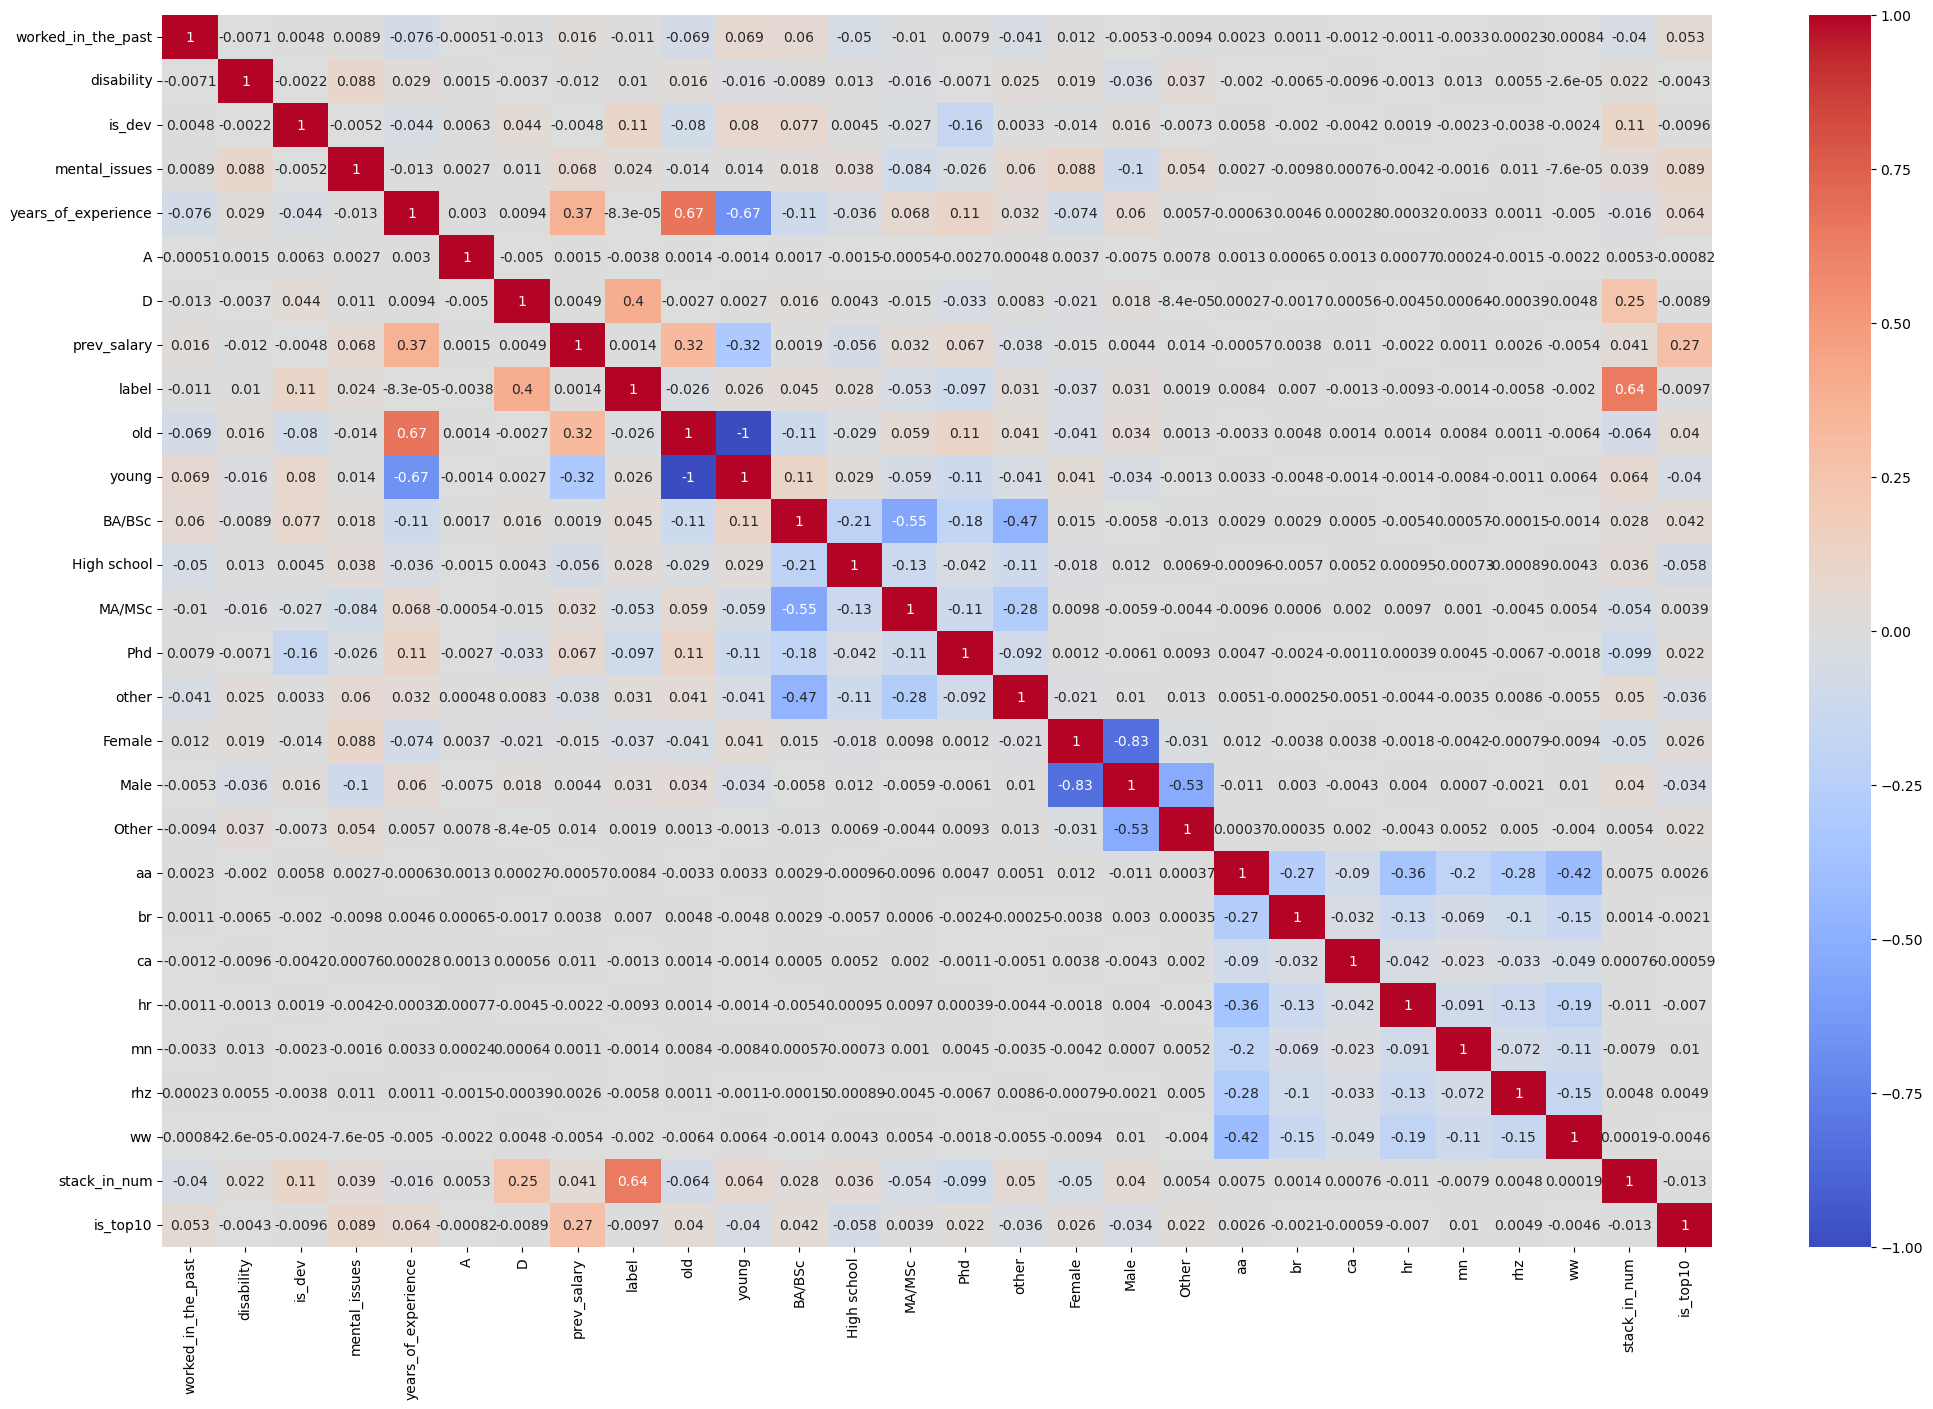

In [28]:
plt.figure(figsize=(25, 16))
sns.heatmap(train_data_imputed.corr(), annot=True, cmap='coolwarm')
plt.show()

We can see a surprisingly high positive correlation between anonymous feature“B” and “years of experience”, and that “young” has a high negative correlation with “B” and “years of experience”. <br>
The negative correlation between “young” and “years of experience” is expected, as someone who hasn’t had much life experience, wouldn’t have much work experience either. <br>
Note: You can't see the feature "B" here because it was removed before running the Iterative Imputer. The original correlation matrix can be found in the appendix.

We will split the data into train, validation, and test:

In [29]:
X = train_data_imputed.drop(columns = ["label"])
y = train_data_imputed ["label"]
# Split into train and temp set (containing test and validation)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state = our_random_state)
# Split temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state = our_random_state)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (32022, 27)
y_train shape: (32022,)
X_val shape: (10674, 27)
y_val shape: (10674,)
X_test shape: (10675, 27)
y_test shape: (10675,)


# Dimensionality Recduction

The dimensionality of the data is an issue. A complex dataset has a high variance and very low bias, which leads to overfitting. <br>
Since our Logistic Regression model is underfitted, we decided not to apply any dimensionality reduction techniques in order to increase the complexity of the model. This raised the AUC score, however the model is still underfitted.<br>
The other models don’t benefit from the high dimensionality either.<br>
<br>
The main issue with having a high dimensionality is that it causes a myriad of problems that hurt both the accuracy and the computational efficiency of the models. One such problem is that  it makes the data sparse, meaning that most of the high-dimensional space is empty. This makes clustering and classification tasks challenging. Another issue is that more dimensions mean more computational resources and time are needed to process the data. There is also the risk of overfitting. With higher dimensions, models can become overly complex, fitting to the noise rather than the underlying pattern. This reduces the model's ability to generalize to new data.
Another problem has to do with distances, to clarify the difference in distances between data points tends to become negligible in high dimensions, making measures like Euclidean distance less meaningful. There is also the degradation of model performance, this is especially true for models that rely on distance like KNN. Lastly,  High-dimensional data is hard to visualize, making exploratory data analysis more difficult. <br>
<br>
In order to determine whether the dimensionality of the data set is a problem, we first trained the models on the original data set without any treatments. Afterwards, we applied PCA on all the models and checked to see if there was an improvement to the AUC score.


PCA:

In [30]:
def reduce_dimensionsPCA (X_train_pca, X_val_pca,p):
    scaler = StandardScaler()
    X_trainR = scaler.fit_transform(X_train_pca)
    pca = PCA(p)
    pca.fit(X_trainR)
    X_train_reduced = pca.fit_transform(X_trainR)
    print(f"X_val_pca pre transform: {X_val_pca.shape}")
    X_val_pca = pca.transform(X_val_pca)
    print(f"X_val_pca after transform: {X_val_pca.shape}")
    print(f"number of dimensions: {X_train_reduced.shape[1]}")
    return pd.DataFrame(X_train_reduced), pd.DataFrame(X_val_pca)

It is important to note that we instructed the PCA to keep 99% of the variance. <br>
We initially used PCA in order to lower the dimensionality of the data. We thought it would  improve the performance of the logistic regression model. In order to do so, we had to make use of standard scaler’s fit_transform in order to calculate mean and standard deviation because PCA assumes that the data follows standard normal distribution. Using this method, we reduced the dimensions from 31 features to 20. As a result, we got an improved AUC score. This was before we realized that we had included the validation set in the training set, which made our results wildly inaccurate. <br>
<br>
After running the logistic regression model again on the appropriate training data, we realized that the model was underfitted. Hence, we elected not to use dimension reduction in order to keep the model at a higher dimensionality so that it would solve the underfitting problem. <br>
<br>
We used PCA for KNN and the Neural Network. This is because high dimensionality deteriorates the performance of KNN models. The use of PCA improved the KNN model’s AUC score by 0.002.


RFE:

In [31]:
def reduce_dimensionsRFE (X_train_rfc, y_train_rfc, desired_estimator):
    print(f"The shape of X_selected: {X_train_rfc.shape} \n The shape of y_train: {y_train_rfc.shape}")
    # Create RFE object
    rfe = RFE(estimator = desired_estimator, n_features_to_select = None, step = 1, verbose = 0)
    # Fit RFE to data
    rfe = rfe.fit(X_train_rfc, y_train_rfc)
    # Get indices of selected features
    selected_features = rfe.support_
    print(f"Amount of features selceted: {len(selected_features)}")
    # Get selected feature names
    feature_names = X_train_rfc.columns[selected_features]
    return feature_names

We tried to use PCA on the forest as well but for whatever reason, it seemed to output a worse AUC score and worse performance in comparison to without the PCA. This led us to decide on a different dimensionality reduction method, namely Recursive Feature Elimination (RFE). Recursive feature elimination is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. Features are ranked by the model’s coef_ or feature_importances_ attributes, and by recursively eliminating a small number of features per loop, RFE attempts to eliminate dependencies and collinearity that may exist in the model.

# Scaling

The data set as it was received, was not normalized, evidenced by the existence of outliers and data that is measured on different scales. The data does need to undergo normalization.
We normalized all of the data using Robust Scaling. For the purpose of the KNN model, when the data is not scaled down some values will appear larger than others which creates a “bias”. This bias causes the model to output inaccurate predictions.
The distance between each neighbor might seem too big. In reality, the proportions are just different in those features, hence the big distance difference. Robust Scaling also helped us with Logistic Regression and the MLP. Although Logistic Regression doesn’t require the data to be normalized in theory, the model didn’t perform well until we applied the Robust Scaling on the data it was training on. MLP on the other hand is much more sensitive to different scales between the features, because features with larger scales tend to dominate the gradient updates, leading to inaccurate and bad model performance.


MinMax Scaling

In [32]:
def MinMaxScaling(X):
    scaler_min_max = MinMaxScaler()
    X = pd.DataFrame(scaler_min_max.fit_transform(X), columns = X.columns)
    return X

Robust Scaling

In [33]:
def RobustScaling(X):
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    return pd.DataFrame(X_scaled, columns = X.columns)

For the KNN model and the Multi Layer Perceptron model we decided to use Robust Scaling, since it gave us much better results than MinMax scaling

# Logistic Regression

Hyper parameters selection:

In [34]:
# Reduce dimensions
X_train_pca, X_val_pca = reduce_dimensionsPCA(X_train, X_val, 0.99)
X_train_MinMax_scaled = MinMaxScaling(X_train)
X_val_MinMax_scaled = MinMaxScaling(X_val)
X_train_Rob_scaled = RobustScaling(X_train)
X_val_Rob_scaled = RobustScaling(X_val)
'''param_grid = {
      'penalty': ['l1', 'l2'],
      'C': np.logspace(-4, 4, 10),
      'solver': ['liblinear', 'saga', 'newton-cg'],
      'max_iter': [100, 200, 300]
  }
lr = LogisticRegression(random_state = our_random_state)
gscv = GridSearchCV(lr, param_grid, cv = 5, scoring= "roc_auc", n_jobs= 5)
print(f"The shape of X_selected: {X_train_pca.shape} \n The shape of y_train: {y_train.shape}")
gscv.fit(X_train_Rob_scaled, y_train)
best_params = gscv.best_params_
best_score = gscv.best_score_
print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")'''

X_val_pca pre transform: (10674, 27)
X_val_pca after transform: (10674, 23)
number of dimensions: 23


'param_grid = {\n      \'penalty\': [\'l1\', \'l2\'],\n      \'C\': np.logspace(-4, 4, 10),\n      \'solver\': [\'liblinear\', \'saga\', \'newton-cg\'],\n      \'max_iter\': [100, 200, 300]\n  }\nlr = LogisticRegression(random_state = our_random_state)\ngscv = GridSearchCV(lr, param_grid, cv = 5, scoring= "roc_auc", n_jobs= 5)\nprint(f"The shape of X_selected: {X_train_pca.shape} \n The shape of y_train: {y_train.shape}")\ngscv.fit(X_train_Rob_scaled, y_train)\nbest_params = gscv.best_params_\nbest_score = gscv.best_score_\nprint(f"Best parameters: {best_params}")\nprint(f"Best score: {best_score}")'

The chosen hyper parameters are: <br>
penalty = l2 <br>
C = 0.046415888336127774 <br>
max_iter = 100 <br>
solver = liblinear <br>
(Explanations about them appear in the appendix)

K fold validation when k = 5:

AUC: 0.9251100165481873
AUC: 0.9301015454504089
AUC: 0.9263401655353365
AUC: 0.9218980482960055
AUC: 0.9289813927698851
Mean AUC: 0.9264862337199646


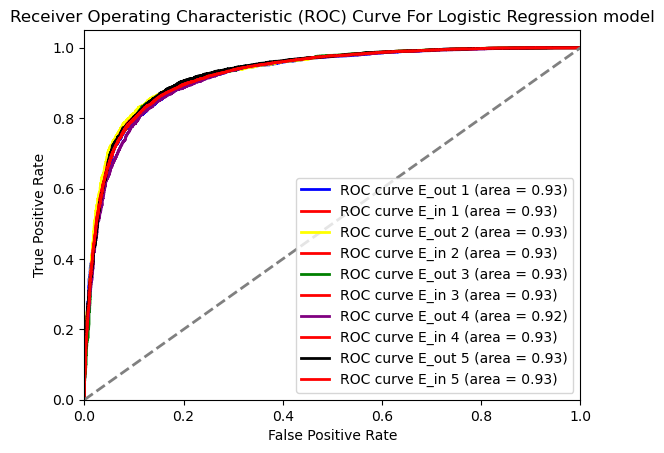

In [35]:
penalty = "l2"
C = 0.046415888336127774
max_iter = 100
solver_lr = "liblinear"
plt.figure()
kf = KFold(n_splits=5, shuffle=True, random_state = our_random_state)
# Initialize a list to store model performance
scores = []
colors = ['blue', 'yellow', 'green', 'purple', 'black']
c = 0
fold = 1
# Iterate through the folds
for train_index, val_index in kf.split(X_train_Rob_scaled):
    X_train_fold, X_val_fold = X_train_Rob_scaled.iloc[train_index], X_train_Rob_scaled.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    # Create and train the model
    model = LogisticRegression(penalty = penalty, C = C, max_iter = max_iter, solver = solver_lr)
    model.fit(X_train_fold, y_train_fold)

    # Make predictions on the validation set
    y_pred = model.predict_proba(X_val_fold) [:, 1]

    # Calculate accuracy (or other metric)
    auc = roc_auc_score(y_val_fold, y_pred)
    scores.append(auc)
    print(f'AUC: {auc}')
# Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_val_fold, y_pred)
# Plot the ROC curve
    plt.plot(fpr, tpr, color= colors [c], lw=2, label=f'ROC curve E_out {fold} (area = {auc:0.2f})')
    auc = roc_auc_score(y_train_fold, model.predict_proba(X_train_fold) [:, 1])
    fpr, tpr, thresholds = roc_curve(y_train_fold, model.predict_proba(X_train_fold) [:, 1])
    plt.plot(fpr, tpr, color= "red", lw=2, label=f'ROC curve E_in {fold} (area = {auc:0.2f})')
    c += 1
    fold += 1


# Calculate the mean accuracy across all folds
print("Mean AUC:", np.mean(scores))
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve For Logistic Regression model')
plt.legend(loc="lower right")
plt.show()

From looking at this graph, we can learn that the model is underfitted. <br>
The reason for that is that the E_out is the same as E_in most of the times, when it should be much higher. <br>
When we see underfitting that means that the model isn't complex enough to capture the pattern in the data, which means that it has a high bias and rather low varaince. <br>
We tried a few times to increase the complexity of the model, however it didn't quite work out for us in the end.

Training the model on the whole train set, and testing the result with the validation set: <br>
We saw that underfitting keeps happening, and in order to tackle this problem, we decided to try and not apply PCA in this case, and use MinMax scaling to normalize the data.<br>
After applying Robust Scaling and not using PCA, we improved the performance of the model considerably, from AUC = 0.5 to AUC = 0.92! However it is still underfitted.

In [36]:
final_lr_model = LogisticRegression(penalty = penalty, C = C, max_iter = max_iter, solver = solver_lr)
final_lr_model.fit(X_train_Rob_scaled, y_train)
y_lr_pred_val = final_lr_model.predict_proba(X_val_Rob_scaled) [:, 1]
print(X_val_Rob_scaled.shape)
print(y_val.shape)
val_lr_auc = roc_auc_score(y_val, y_lr_pred_val)
print(f"Validation for Logistic Regression AUC: {val_lr_auc}")

(10674, 27)
(10674,)
Validation for Logistic Regression AUC: 0.9231259747947147


It appears that the Logistic Regression model is underfitted since its training ROC curve is very close to the ROC curve of the validation and the AUC score is the same in both training and validation. <br>
This might indicate that the Logistic regrssion model with the current hyper parameters is too simple to capture all the varaince in the data and make a good prediction. <br>
Unless we find a way to improve it's performance, we will not choose this model as the best model.

# Random Forest Classifier

At first we attempted to search for the best hyper parameters for Random Forest Classifier using GridSearchCV. <br>
However, we later discovered that there are better ways to find hyper parameters, one of which is skopt gp_minimize. <br>
Not only did it give us better hyper parameters, it also gave them faster.<br>
Here is how it works: <br>
Short for Scikit-Optimize, skopt is a library primarily used for minimizing expensive functions with high levels of noise through sequential model-based optimization. The function we used from the Scikit-Optimize library is gp_minimize. 
Gp_minimize is used to optimize the hyperparameters in a large and complex model. In order to use it, the user must first define a range where the optimal hyperparameter should be found. After which, gp_minimize would evaluate a user-specified number of random points within the range. The evaluations are recorded and the points are assigned values, the optimal function value and corresponding hyperparameter will be used as a benchmark for future iterations of the process. In each iteration, the function is used to find the hyperparameter value that influences the objective function in the desired way (Depending on the type of objective function, higher or lower values indicate a better fit), in comparison to the benchmark. The process continues until all user-specified iterations of Gaussian process regression are performed.  In the evaluated hyperparameters the best hyperparameters will be the ones that cause the highest AUC score.


In [37]:
'''params = {"n_estimators" : [100, 150, 200], "max_depth" : [5, 10, 20], "criterion" : ["gini", "entropy"], "min_samples_leaf" : range(1, 6), "min_samples_split" : range(2, 10)}
rfc = RandomForestClassifier(random_state=our_random_state)
gscv = GridSearchCV(rfc, params, scoring= "roc_auc", n_jobs= 5)
print(f"The shape of X_selected: {X_train_selected.shape} \n The shape of y_train: {y_train.shape}")
gscv.fit(X_train_selected, y_train)
print(f'Runtime: {round(time.time()-t0,2)} seconds')''' #The commented code above was our first attempt at finding the best hyper parameters for the model.
selected_features = reduce_dimensionsRFE(X_train, y_train, RandomForestClassifier())
X_train_rfe = X_train [selected_features]
X_val_rfe = X_val [selected_features]
X_test_rfe = X_test [selected_features]
'''def objective_rf(params): 
    n_estimators, max_depth, min_samples_split, min_samples_leaf, criterion = params
    rf = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),

        criterion=criterion,
        random_state=our_random_state
    )
    score = cross_val_score(rf, X_train_rfe, y_train, cv=5, scoring='roc_auc').mean()
    print("Mean AUC:", score)
    return -score  # Maximize AUC by minimizing negative AUC

# Define the search space
space = [
    (100, 350),  # n_estimators
    (5, 50),    # max_depth
    (2, 20),   # min_samples_split
    (1, 10),   # min_samples_leaf
    ('gini', 'entropy')  # criterion
]

# Optimize
res = gp_minimize(objective_rf, space, n_calls=50, random_state=our_random_state)

# Best parameters and score
best_params = dict(zip(space, res.x))
best_score = -res.fun

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")'''
#Hyper parameters selection methods ^

The shape of X_selected: (32022, 27) 
 The shape of y_train: (32022,)
Amount of features selceted: 27


'def objective_rf(params): \n    n_estimators, max_depth, min_samples_split, min_samples_leaf, criterion = params\n    rf = RandomForestClassifier(\n        n_estimators=int(n_estimators),\n        max_depth=int(max_depth),\n        min_samples_split=int(min_samples_split),\n        min_samples_leaf=int(min_samples_leaf),\n\n        criterion=criterion,\n        random_state=our_random_state\n    )\n    score = cross_val_score(rf, X_train_rfe, y_train, cv=5, scoring=\'roc_auc\').mean()\n    print("Mean AUC:", score)\n    return -score  # Maximize AUC by minimizing negative AUC\n\n# Define the search space\nspace = [\n    (100, 350),  # n_estimators\n    (5, 50),    # max_depth\n    (2, 20),   # min_samples_split\n    (1, 10),   # min_samples_leaf\n    (\'gini\', \'entropy\')  # criterion\n]\n\n# Optimize\nres = gp_minimize(objective_rf, space, n_calls=50, random_state=our_random_state)\n\n# Best parameters and score\nbest_params = dict(zip(space, res.x))\nbest_score = -res.fun\n\nprint

Chosen hyper parameters for the RandomForestClassifier: <br>
n_estimatores = 500 <br>
max_depth = 38 <br>
min_samples_split = 20 <br>
min_samples_leaf = 5 <br>
criterion = "entropy"

AUC: 0.9318830178011945
AUC: 0.9373148752039486
AUC: 0.93388727972229
AUC: 0.9290269688937992
AUC: 0.9352908445060962
Mean AUC: 0.9334805972254656


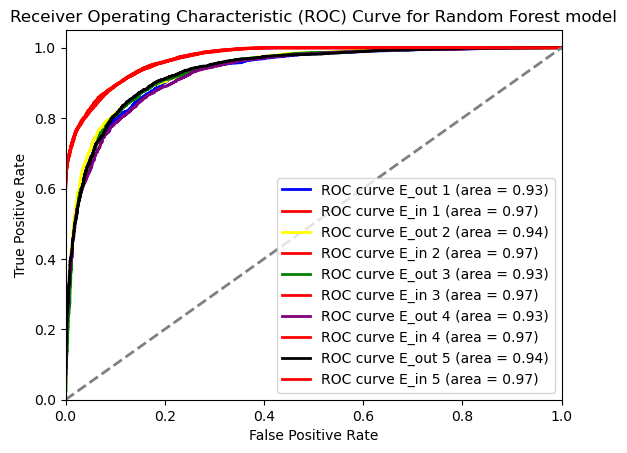

In [38]:
n_estimators = 500
max_depth = 38
min_samples_split = 20
min_samples_leaf = 5
criterion = "entropy"
random_state = our_random_state

kf = KFold(n_splits=5, shuffle=True, random_state=our_random_state)
plt.figure()
# Initialize a list to store model performance
scores = []
colors = ['blue', 'yellow', 'green', 'purple', 'black']
c = 0
fold = 1
# Iterate through the folds
for train_index, val_index in kf.split(X_train_rfe):
    X_train_fold, X_val_fold = X_train_rfe.iloc[train_index], X_train_rfe.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    # Reduce dimensions
    # Create and train the model
    model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, criterion = criterion, random_state = random_state)
    model.fit(X_train_fold, y_train_fold)

    # Make predictions on the validation set
    y_pred = model.predict_proba(X_val_fold) [:, 1]

    # Calculate accuracy (or other metric)
    auc = roc_auc_score(y_val_fold, y_pred)
    scores.append(auc)
    print(f'AUC: {auc}')
# Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_val_fold, y_pred)
# Plot the ROC curve
    plt.plot(fpr, tpr, color= colors [c], lw=2, label=f'ROC curve E_out {fold} (area = {auc:0.2f})')
    auc = roc_auc_score(y_train_fold, model.predict_proba(X_train_fold) [:, 1])
    fpr, tpr, thresholds = roc_curve(y_train_fold, model.predict_proba(X_train_fold) [:, 1])
    plt.plot(fpr, tpr, color= "red", lw=2, label=f'ROC curve E_in {fold} (area = {auc:0.2f})')
    c += 1
    fold += 1


# Calculate the mean accuracy across all folds
print("Mean AUC:", np.mean(scores))
#auc = roc_auc_score(y_test, y_pred_proba)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest model')
plt.legend(loc="lower right")
plt.show()

From this plot we can learn that the model isn't overfitted because the gap between the E_out and E_in is fairly small. <br>
The model is also not underfitted because the E_in is bigger than E_out. <br>
In conclusion, the model is positioned in a good spot and it yields a good AUC socre as well.

We will now train the RandomForestClassifier on the whole training set after feature elimination, and check the AUC score with the validation:

In [39]:
final_rfc_model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, criterion = criterion, random_state = our_random_state)
final_rfc_model.fit(X_train_rfe, y_train)
y_rfc_pred_val = final_rfc_model.predict_proba(X_val_rfe) [:, 1]
print(X_val_rfe.shape)
print(y_val.shape)
val_rfc_auc = roc_auc_score(y_val, y_rfc_pred_val)
print(f"Validation for Random Forest Classifier AUC: {val_rfc_auc}")

(10674, 13)
(10674,)
Validation for Random Forest Classifier AUC: 0.9320087387313165


Since the model performs well on the validation set (close to its performance on the K-folds) and the gap from the train AUC curve isn't to big, we can confidently say that our model isn't overfitted.

We will now take a look at the feature importance of our forest model. See if we can actually learn something from it:

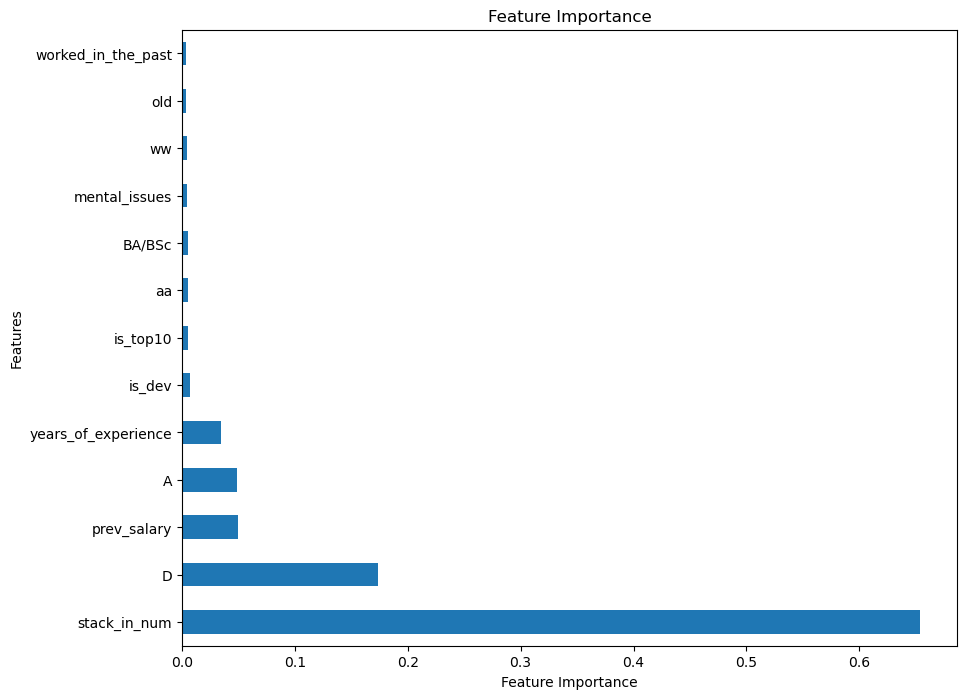

In [40]:
importances = final_rfc_model.feature_importances_
feature_importances = pd.Series(importances, index = X_train_rfe.columns)
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances.plot(kind='barh', figsize=(10, 8))
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

Accidentally included ID in the list of relevant features, it came out as third most important (it was later removed and cannot be seen anymore, its located in the appendix). Other than that, the graph shows that the most important feature in determining the likelihood of an applicant being accepted to work is the number of coding languages they know (we can see that stack_in_num is the largest bar and exceeds 50%). Following coding languages, we see that the most relevant features are anonymous feature D, which we can’t make any deductions from because we don’t know what it is, and the applicant’s previous salary. A possible explanation as to why the previous salary of an applicant is given so much importance is that it correlates to the individual’s past job experience and country of residence. To clarify, the annual salary of a tech worker varies greatly in each country. For example, an individual with a previous salary exceeding $100,000 USD is likely to be from the United States, where we observed a large acceptance rate of individuals who apply for HighTech jobs. Alternatively, an individual with a high previous salary was perchance employed in a high paying position, making them a more credible candidate which in turn would influence their chance to be accepted to work in a HighTech position.

# Confusion Matrix

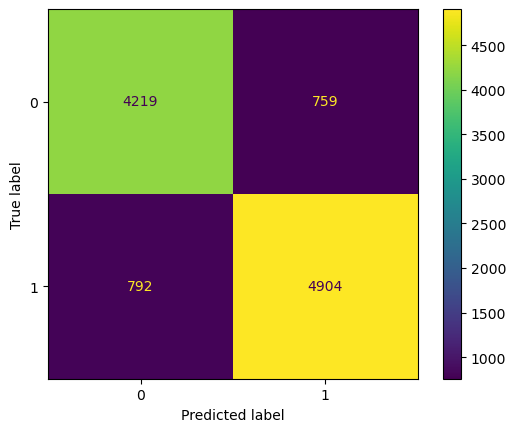

In [41]:
threshold = 0.5
y_pred_val = (y_rfc_pred_val >= threshold).astype(int)
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()



From the Confusion Matrix we can learn that the overall accuaracy of the model is (sum of diagonals divided by all the cells) 85%. <br>
It seems like its struggling to identify workers who were accepted, rather than not accepted (not by much). Which means it has a relatively minor tendancy to classify an applicant as someone who wasn't accepted. <br>
If we would look at the TPR vs TNR, we can see that TPR = 86%, and the TNR = 84%.<br>

# KNN model <br>

Since KNN is very sensitive to overfitting, its pretty much mandatory to use PCA/RFC on the data before training the model.

We decided to use Robust Scaling on the KNN because it improved our AUC performance significantly

In [42]:
X_train_data_scaled = RobustScaling(X_train)
X_val_scaled = RobustScaling(X_val)
X_train_data_scaled_pca, X_val_scaled_pca = reduce_dimensionsPCA(X_train_data_scaled, X_val_scaled, 0.99)

X_val_pca pre transform: (10674, 27)
X_val_pca after transform: (10674, 23)
number of dimensions: 23


We will select the best hyper parameters accodring to gp_minimize:

In [43]:

'''def objective_knn(params): 
    n_neighbors, weights, algorithm, leaf_size, p = params
    knn = KNeighborsClassifier(
        n_neighbors = int(n_neighbors),
        weights = weights,
        algorithm = algorithm,
        leaf_size = int(leaf_size),
        p = int(p)
    )
    knn.fit(X_train_data_scaled_pca, y_train)
    score = roc_auc_score(y_train, knn.predict_proba(X_train_data_scaled_pca)[:, 1])
    print(f"AUC score is: {score}")
    return -score  # Maximize AUC by minimizing negative AUC

params_knn = [
    (1, 31), #n_neighbors
    ('uniform', 'distance'), #weights
    ('auto', 'ball_tree', 'kd_tree', 'brute'), #algorithm
    (1, 50), #leaf_size
    (1, 3) #p
]
res = gp_minimize(objective_knn, params_knn, n_calls=50, random_state = our_random_state)

# Best parameters and score
best_params = dict(zip(params_knn, res.x))
best_score = -res.fun

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")'''
# Best hyper parameters search for KNN model ^

'def objective_knn(params): \n    n_neighbors, weights, algorithm, leaf_size, p = params\n    knn = KNeighborsClassifier(\n        n_neighbors = int(n_neighbors),\n        weights = weights,\n        algorithm = algorithm,\n        leaf_size = int(leaf_size),\n        p = int(p)\n    )\n    knn.fit(X_train_data_scaled_pca, y_train)\n    score = roc_auc_score(y_train, knn.predict_proba(X_train_data_scaled_pca)[:, 1])\n    print(f"AUC score is: {score}")\n    return -score  # Maximize AUC by minimizing negative AUC\n\nparams_knn = [\n    (1, 31), #n_neighbors\n    (\'uniform\', \'distance\'), #weights\n    (\'auto\', \'ball_tree\', \'kd_tree\', \'brute\'), #algorithm\n    (1, 50), #leaf_size\n    (1, 3) #p\n]\nres = gp_minimize(objective_knn, params_knn, n_calls=50, random_state = our_random_state)\n\n# Best parameters and score\nbest_params = dict(zip(params_knn, res.x))\nbest_score = -res.fun\n\nprint(f"Best parameters: {best_params}")\nprint(f"Best score: {best_score}")'

We are not exactly happy that gp_minimize is offering to use no neighbors at all, so we will choose our own neighbors however we will keep the rest of the hyper parameters as suggested: <br>
chosen_n_neighbors = 10 <br>
chosen_weights = "distance" <br>
chosen_algorithm = "brute" <br>
chosen_leaf_size = 6 <br>
chosen_p = 2 (Eucladian distance)

AUC: 0.8680349391247665
AUC: 0.8788204134109883
AUC: 0.8784790796058402
AUC: 0.8698662721337103
AUC: 0.8727387522948004
Mean AUC: 0.8735878913140211


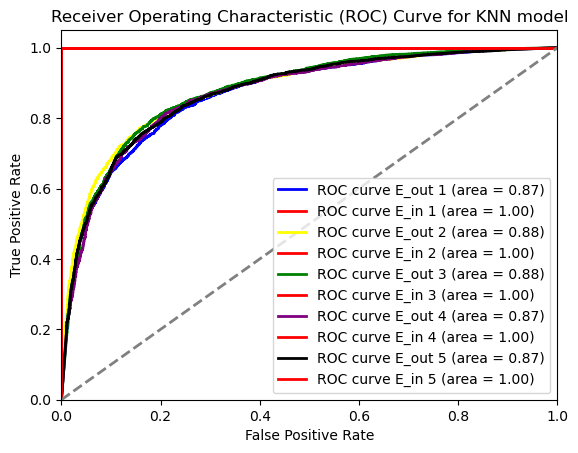

In [44]:
kf = KFold(n_splits=5, shuffle=True, random_state = our_random_state)
chosen_n_neighbors = 10
chosen_weights = 'distance'
chosen_algorithm = 'brute'
chosen_leaf_size = 6
chosen_p = 2 #Eucladian distance

scores = []
colors = ['blue', 'yellow', 'green', 'purple', 'black']
c = 0
fold = 1

for train_index, val_index in kf.split(X_train_data_scaled_pca):
    X_train_fold, X_val_fold = X_train_data_scaled_pca.iloc[train_index], X_train_data_scaled_pca.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    # Create and train the model
    model = KNeighborsClassifier(n_neighbors = chosen_n_neighbors, weights = chosen_weights, algorithm = chosen_algorithm, leaf_size = chosen_leaf_size, p = chosen_p)
    model.fit(X_train_fold, y_train_fold)

    # Make predictions on the test set
    y_pred = model.predict_proba(X_val_fold) [:, 1]

    # Calculate AUC
    auc = roc_auc_score(y_val_fold, y_pred)
    scores.append(auc)
    print(f'AUC: {auc}')
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_val_fold, y_pred)
    # Plot the ROC curve
    plt.plot(fpr, tpr, color= colors [c], lw=2, label=f'ROC curve E_out {fold} (area = {auc:0.2f})')
    auc = roc_auc_score(y_train_fold, model.predict_proba(X_train_fold) [:, 1])
    fpr, tpr, thresholds = roc_curve(y_train_fold, model.predict_proba(X_train_fold) [:, 1])
    plt.plot(fpr, tpr, color= "red", lw=2, label=f'ROC curve E_in {fold} (area = {auc:0.2f})')
    c += 1
    fold += 1

# Calculate the mean accuracy across all folds
print("Mean AUC:", np.mean(scores))
#auc = roc_auc_score(y_test, y_pred_proba)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for KNN model')
plt.legend(loc="lower right")
plt.show()


We can learn from this graph that it is highly unlikely that the model is overfitted, since each fold got a relatively good score, however it is not "1" as all of the E_ins suggest.

We will check the model's performance with the validation set that it never saw before:

In [45]:
final_knn_model = KNeighborsClassifier(n_neighbors = chosen_n_neighbors, weights = chosen_weights, algorithm = chosen_algorithm, leaf_size = chosen_leaf_size, p = chosen_p)
final_knn_model.fit(X_train_data_scaled_pca, y_train)
y_knn_pred_val = final_knn_model.predict_proba(X_val_scaled_pca) [:, 1]
print(X_val_scaled_pca.shape)
print(y_val.shape)
val_knn_auc = roc_auc_score(y_val, y_knn_pred_val)
print(f"Validation for KNN AUC: {val_knn_auc}")

(10674, 23)
(10674,)
Validation for KNN AUC: 0.8901873475031713


At the moment, the model is very overfitted. It gets 0.88 AUC when running on each K-fold, However when we run it on the validation set, it performs very poorly (AUC = 0.49). <br>
We start by trying to scale the data with MinMax, which increased the AUC by 14%. <br>
Update: We used Robust Scaling on the model with PCA, which improved our AUC score on the validation to AUC = 0.8901. <br>
Hence, the model is not overfitted anymore!

# Multi Layer Perceptron

We will use the data after performing PCA, since RFE is not supported with Neural Network classifiers.

We will look for the best hyper parameters using gp_minimize.

In [46]:
'''def objective_mlp(params): 
    first_layer_size, second_layer_size, activation, solver, alpha, batch_size, learning_rate, max_iter = params
    mlp = MLPClassifier(
        hidden_layer_sizes= (int(first_layer_size), int(second_layer_size)),
        activation = activation,
        solver = solver,
        alpha = float(alpha),
        batch_size = int(batch_size),
        learning_rate = learning_rate,
        max_iter = max_iter,
        early_stopping = True
    )
    mlp.fit(X_train_pca, y_train)
    score = cross_val_score(mlp, X_train_pca, y_train, cv=5, scoring='roc_auc').mean()
    print("Mean AUC:", score)
    return -score  # Maximize AUC by minimizing negative AUC

params_mlp = [
    (100, 150), #first layer size
    (20, 50), #second layer size
    ('identity', 'logistic', 'tanh', 'relu'), #activation
    ('lbfgs', 'sgd', 'adam'), #solver
    (0.0001, 0.1), #alpha
    (32, 256), #batch_size
    ("constant", "invscaling", "adaptive"), #learning_rate
    (100, 1000)#max_iter
    
]
res = gp_minimize(objective_mlp, params_mlp, n_calls = 20, random_state = our_random_state)

# Best parameters and score
best_params = dict(zip(params_mlp, res.x))
best_score = -res.fun

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")'''

'def objective_mlp(params): \n    first_layer_size, second_layer_size, activation, solver, alpha, batch_size, learning_rate, max_iter = params\n    mlp = MLPClassifier(\n        hidden_layer_sizes= (int(first_layer_size), int(second_layer_size)),\n        activation = activation,\n        solver = solver,\n        alpha = float(alpha),\n        batch_size = int(batch_size),\n        learning_rate = learning_rate,\n        max_iter = max_iter,\n        early_stopping = True\n    )\n    mlp.fit(X_train_pca, y_train)\n    score = cross_val_score(mlp, X_train_pca, y_train, cv=5, scoring=\'roc_auc\').mean()\n    print("Mean AUC:", score)\n    return -score  # Maximize AUC by minimizing negative AUC\n\nparams_mlp = [\n    (100, 150), #first layer size\n    (20, 50), #second layer size\n    (\'identity\', \'logistic\', \'tanh\', \'relu\'), #activation\n    (\'lbfgs\', \'sgd\', \'adam\'), #solver\n    (0.0001, 0.1), #alpha\n    (32, 256), #batch_size\n    ("constant", "invscaling", "adaptive")

The chosen hyper parameters for the Multi Layer Perceptron: <br>
hidden_layer_sizes = (113, 21) <br>
activation = "relu" <br>
solver = "lbfgs" <br>
alpha = 0.018153987421074984 <br>
batch_size = 103 <br>
learning_rate = "constant" <br>
max_iter = 438

AUC: 0.874992185905851
AUC: 0.87707339279126
AUC: 0.8787070653469043
AUC: 0.8769569441914132
AUC: 0.8846901309383163
Mean AUC: 0.8784839438347489


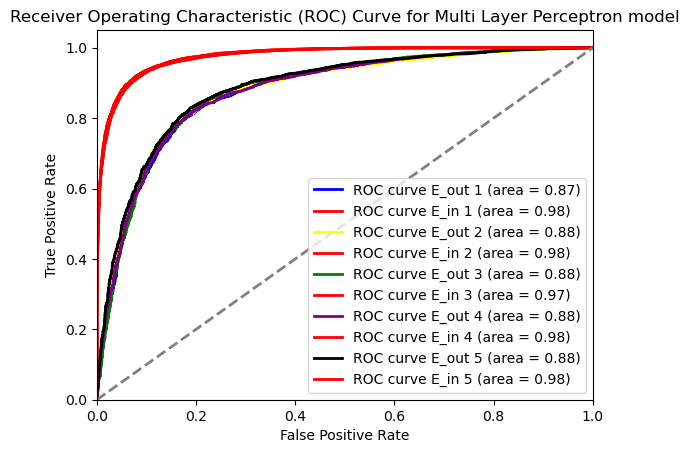

In [47]:
#Hyper parameters we chose to use: hidden_layer_sizes = (113, 21), activation = "relu", solver = "lbfgs", alpha = 0.018153987421074984, batch_size = 103, learning_rate = "constant", max_iter = 438
first_layer_size = 113
second_layer_size = 21
activation = "relu"
solver = "lbfgs"
alpha = 0.018153987421074984
batch_size = 103
learning_rate = "constant"
max_iter = 438

kf = KFold(n_splits=5, shuffle=True, random_state=our_random_state)
plt.figure()
# Initialize a list to store model performance
scores = []
colors = ['blue', 'yellow', 'green', 'purple', 'black']
c = 0
fold = 1

# Iterate through the folds
for train_index, val_index in kf.split(X_train_data_scaled_pca):
    X_train_fold, X_val_fold = X_train_data_scaled_pca.iloc[train_index], X_train_data_scaled_pca.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    # Create and train the model
    mlp = MLPClassifier(hidden_layer_sizes = (first_layer_size, second_layer_size), activation = activation, solver = solver, alpha = alpha, batch_size = batch_size, learning_rate = learning_rate, max_iter = max_iter, random_state = our_random_state)
    mlp.fit(X_train_fold, y_train_fold)

    # Make predictions on the validation set
    y_pred = mlp.predict_proba(X_val_fold) [:, 1]

    # Calculate accuracy (or other metric)
    auc = roc_auc_score(y_val_fold, y_pred)
    scores.append(auc)
    print(f'AUC: {auc}')
# Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_val_fold, y_pred)
# Plot the ROC curve
    plt.plot(fpr, tpr, color= colors [c], lw=2, label=f'ROC curve E_out {fold} (area = {auc:0.2f})')
    auc = roc_auc_score(y_train_fold, mlp.predict_proba(X_train_fold) [:, 1])
    fpr, tpr, thresholds = roc_curve(y_train_fold, mlp.predict_proba(X_train_fold) [:, 1])
    plt.plot(fpr, tpr, color= "red", lw=2, label=f'ROC curve E_in {fold} (area = {auc:0.2f})')
    c += 1
    fold += 1


# Calculate the mean accuracy across all folds
print("Mean AUC:", np.mean(scores))
#auc = roc_auc_score(y_test, y_pred_proba)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi Layer Perceptron model')
plt.legend(loc="lower right")
plt.show()

We can learn from this graph that the model is neither overfitted or underfitted since the E_out values are smaller than E_in, but still relatively close to each other.

We will attempt to train the model on the whole train data, and check how it performs on the validation:

In [48]:
final_mlp_model = MLPClassifier(hidden_layer_sizes = (first_layer_size, second_layer_size), activation = activation, solver = solver, alpha = alpha, batch_size = batch_size, learning_rate = learning_rate, max_iter = max_iter, random_state = our_random_state)
final_mlp_model.fit(X_train_data_scaled_pca, y_train)
y_mlp_pred_val = final_mlp_model.predict_proba(X_val_scaled_pca) [:, 1]
print(X_train_data_scaled_pca.shape)
print(y_val.shape)
val_mlp_auc = roc_auc_score(y_val, y_mlp_pred_val)
print(f"Validation for MLP AUC: {val_mlp_auc}")

(32022, 23)
(10674,)
Validation for MLP AUC: 0.8915638570948128


At the moment, the model is very overfitted. It gets 0.9 AUC when running on each K-fold, However when we run it on the validation set, it performs very poorly. <br>
We start by trying to scale the data with MinMax, which increased the AUC by 15%. <br>
Update: We used Robust Scaling on the model with PCA, which improved our AUC score on the validation to AUC = 0.8915, which is much closer to 0.91. <br>
Hence, the model is not overfitted anymore!

# Checking our chosen model on the test set

Our chosen model is Random Forest Classifier, since it had the best AUC score. We will train it on the train and validation sets, and check its performance with the test set as a final quality check before predicting the values for test.csv:

In [49]:
n_estimators = 500
max_depth = 38
min_samples_split = 20
min_samples_leaf = 5
criterion = "entropy"
random_state = our_random_state
X_train_and_val_rfe = pd.concat([X_train_rfe, X_val_rfe], ignore_index = True)
y_train_and_val = pd.concat([y_train, y_val], ignore_index = True)
final_model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, criterion = criterion, random_state = random_state)
final_model.fit(X_train_and_val_rfe, y_train_and_val)
y_pred_test = final_model.predict_proba(X_test_rfe) [:, 1]
test_auc = roc_auc_score(y_test, y_pred_test)
print(f"Test for RFC AUC: {test_auc}")

Test for RFC AUC: 0.9374727727012976


# Pipeline

(Final predictions are here in the pipeline)

In [50]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
our_random_state = 4

#Removing outliers according to A and B in train
train_data = train_data.drop(train_data [train_data ["A"] > 30].index)
train_data = train_data.drop(train_data [train_data ["A"] < -16].index)
train_data = train_data.drop(train_data [train_data ["B"] > 40].index)

#Removing outliers according to prev_salary in train
train_data = train_data.drop(train_data [train_data ["prev_salary"] < 5000].index)

#Dealing with worked_in_the_past NaN values in train and test
train_data_copy = train_data.copy()
train_data_copy = train_data_copy.reset_index(drop = True)
train_data_copy ["worked_in_the_past"].fillna("F", inplace= True)
train_data_copy ["worked_in_the_past"] = train_data_copy ["worked_in_the_past"].map({"T": 1, "F": 0})

test_data_copy = test_data.copy()
test_data_copy ["worked_in_the_past"].fillna("F", inplace= True)
test_data_copy ["worked_in_the_past"] = test_data_copy ["worked_in_the_past"].map({"T": 1, "F": 0})

#Dealing with years_of_experience NaN values in train and test
train_data_copy ["years_of_experience"].fillna(train_data_copy ["years_of_experience"].median(), inplace= True)
test_data_copy ["years_of_experience"].fillna(train_data_copy ["years_of_experience"].median(), inplace= True)

#Dealing with age_group NaN values in train and test
age_check = train_data_copy ["years_of_experience"] + 18
age_check = (age_check <= 35).map({True: 'young', False: 'old'})
train_data_copy ["age_group"].fillna(age_check, inplace= True)

age_check = test_data_copy ["years_of_experience"] + 18
age_check = (age_check <= 35).map({True: 'young', False: 'old'})
test_data_copy ["age_group"].fillna(age_check, inplace= True)

#Dealing with is_dev NaN values and transforming it into a numerical feature
dev_count = train_data_copy ["is_dev"]
dev_count = dev_count.map({"developer": 1, "non-developer":0})
proba_dev = dev_count.sum() / dev_count.count() #Calculate the probability of being a developer in our data
print(f"The probability of being a developer: {proba_dev}")
np.random.seed(4)
dev_count_random = pd.Series(np.random.random(len(dev_count))) #len(dev_cout) How many random variables I want
dev_count_random = (dev_count_random <= proba_dev).map({True: 1, False: 0}) #If we didn't pass the threshold (the calculated probability above) then its a developer. else: None developer
train_data_copy ["is_dev"] = train_data_copy ["is_dev"].map({"developer": 1, "non-developer":0})
train_data_copy ["is_dev"].fillna(dev_count_random, inplace= True)

dev_count_random = pd.Series(np.random.random(len(test_data_copy ["is_dev"]))) #len(dev_cout) How many random variables I want
dev_count_random = (dev_count_random <= proba_dev).map({True: 1, False: 0}) #If we didn't pass the threshold (the calculated probability above) then its a developer. else: None developer
test_data_copy ["is_dev"] = test_data_copy ["is_dev"].map({"developer": 1, "non-developer":0})
test_data_copy ["is_dev"].fillna(dev_count_random, inplace= True)

#Dealing with disability NaN values and transforming them into a numerical feature
dis_count = train_data_copy ["disability"]
dis_count = dis_count.map({"Yes": 1, "No":0})
proba_dis = dis_count.sum() / dis_count.count() #Calculate the probability of being disable in our data
print(f"The probability of being disable: {proba_dis}")
dis_count_random = pd.Series(np.random.random(len(dis_count)))
dis_count_random = (dis_count_random <= proba_dis).map({True: 1, False: 0}) #If we didn't pass the threshold (the calculated probability above) then the individual is disable. else: not disable
train_data_copy ["disability"] = train_data_copy ["disability"].map({"Yes": 1, "No": 0})
train_data_copy ["disability"].fillna(dis_count_random, inplace= True)

dis_count_random = pd.Series(np.random.random(len(test_data_copy ["disability"])))
dis_count_random = (dis_count_random <= proba_dis).map({True: 1, False: 0}) #If we didn't pass the threshold (the calculated probability above) then the individual is disable. else: not disable
test_data_copy ["disability"] = test_data_copy ["disability"].map({"Yes": 1, "No": 0})
test_data_copy ["disability"].fillna(dis_count_random, inplace= True)

#Dealing with education NaN values
train_data_copy ["education"].fillna("other", inplace= True)
test_data_copy ["education"].fillna("other", inplace= True)

#Dealing with sex NaN values
sex_count = train_data_copy ["sex"].value_counts()
num_of_other = sex_count.loc["Other"]
num_of_female = sex_count.loc["Female"]
num_of_male = sex_count.loc["Male"]
proba_other = num_of_other / train_data_copy ["sex"].count()
proba_female = num_of_female / train_data_copy ["sex"].count()
proba_male = num_of_male / train_data_copy ["sex"].count()
sex_count_random = pd.Series(np.random.random(len(train_data_copy)), index = train_data_copy.index)
categories = ["Other", "Female", "Male"]
bins = [0, proba_other, proba_female, 1]
sex_count_random = pd.cut(sex_count_random, bins=bins, labels=categories)
train_data_copy ["sex"].fillna(sex_count_random, inplace= True)

sex_count_random = pd.Series(np.random.random(len(test_data_copy)), index = test_data_copy.index)
sex_count_random = pd.cut(sex_count_random, bins=bins, labels=categories)
test_data_copy ["sex"].fillna(sex_count_random, inplace= True)

#Dealing with mental_issues NaN values
mi_count = train_data_copy ["mental_issues"]
mi_count = mi_count.map({"Yes": 1, "No":0})
proba_mi = mi_count.sum() / mi_count.count() #Calculate the probability of being mentally ill in our data
print(f"The probability of being mentally ill: {proba_mi}")
mi_count_random = pd.Series(np.random.random(len(mi_count)))
mi_count_random = (mi_count_random <= proba_mi).map({True: 1, False: 0}) #If we didn't pass the threshold (the calculated probability above) then the individual is disable. else: not disable
train_data_copy ["mental_issues"] = train_data_copy ["mental_issues"].map({"Yes": 1, "No":0})
train_data_copy ["mental_issues"].fillna(mi_count_random, inplace= True)

mi_count_random = pd.Series(np.random.random(len(test_data_copy ["mental_issues"])))
mi_count_random = (mi_count_random <= proba_mi).map({True: 1, False: 0}) #If we didn't pass the threshold (the calculated probability above) then the individual is disable. else: not disable
test_data_copy ["mental_issues"] = test_data_copy ["mental_issues"].map({"Yes": 1, "No":0})
test_data_copy ["mental_issues"].fillna(mi_count_random, inplace= True)

#Dealing with NaN values in A, B, D
train_data_copy ["A"].fillna(train_data_copy ["A"].median(), inplace= True)
train_data_copy ["B"].fillna(train_data_copy ["B"].median(), inplace= True)
train_data_copy ["D"].fillna(train_data_copy ["D"].median(), inplace= True)

test_data_copy ["A"].fillna(train_data_copy ["A"].median(), inplace= True)
test_data_copy ["B"].fillna(train_data_copy ["B"].median(), inplace= True)
test_data_copy ["D"].fillna(train_data_copy ["D"].median(), inplace= True)

#Dealing with NaN values in C
train_data_copy ["C"].fillna("aa", inplace = True)

test_data_copy ["C"].fillna("aa", inplace = True)

#Dealing with NaN values in countries
train_data_copy ["country"].fillna("United States of America", inplace= True)
test_data_copy ["country"].fillna("United States of America", inplace= True)

#Creating dummies for the categorial features for both train and test
age_dummies_train = pd.get_dummies(train_data_copy["age_group"])
educ_dummies_train = pd.get_dummies(train_data_copy["education"])
sex_dummies_train = pd.get_dummies(train_data_copy["sex"])
c_dummies_train = pd.get_dummies(train_data_copy ["C"])
train_data_copy = pd.concat([train_data_copy, age_dummies_train, educ_dummies_train, sex_dummies_train, c_dummies_train], axis = 1)

educ_dummies_test = pd.get_dummies(test_data_copy["education"]) 
age_dummies_test = pd.get_dummies(test_data_copy["age_group"])
sex_dummies_test = pd.get_dummies(test_data_copy["sex"])
c_dummies_test = pd.get_dummies(test_data_copy ["C"])
test_data_copy = pd.concat([test_data_copy, age_dummies_test, educ_dummies_test, sex_dummies_test, c_dummies_test], axis = 1)

#Adding our own features to both test and train
#Adding stack_in_num
def count_semicolons(text):
  if type(text) == str:
    return text.count(';')
  else:
    return None

train_data_copy ["stack_in_num"] = train_data_copy ["stack_experience"].astype(str)
train_data_copy ["stack_in_num"] = train_data_copy ["stack_in_num"].replace("nan", np.nan)
stack_in_num = train_data_copy['stack_in_num'].apply(count_semicolons)
train_data_copy ["stack_in_num"] = stack_in_num
# Doing the same thing for the test data.
test_data_copy ["stack_in_num"] = test_data_copy ["stack_experience"].astype(str)
test_data_copy ["stack_in_num"] = test_data_copy ["stack_in_num"].replace("nan", np.nan)
stack_in_num = test_data_copy ['stack_in_num'].apply(count_semicolons)
test_data_copy ["stack_in_num"] = stack_in_num

#Adding is_top10
cap = 10 
targetCol = train_data_copy["country"]
counts = targetCol.value_counts()[:cap].index.tolist()
print(counts)
train_data_copy ["is_top10"] = train_data_copy ["country"].isin(counts)

test_data_copy ["is_top10"] = test_data_copy ["country"].isin(counts) # Adding the new feature to the test data
test_data_copy.head(50)

#Filling missing values in prev_salary and stack_in_num for both train and test:
numerical_cols = train_data_copy.select_dtypes(include=['number'])
numerical_cols.drop(columns = "B", inplace = True)
non_numerical_cols = train_data_copy.select_dtypes(exclude=['number'])
# Initialize IterativeImputer
imputer = IterativeImputer()
# Fit and transform the numerical columns
numerical_imputed = imputer.fit_transform(numerical_cols)
# Convert the result back to a DataFrame
numerical_imputed_df = pd.DataFrame(numerical_imputed, columns=numerical_cols.columns)
# Recombine the imputed numerical columns with the non-numerical columns
train_data_imputed = pd.concat([numerical_imputed_df, non_numerical_cols.reset_index(drop=True)], axis=1)
print(train_data_imputed.isna().sum())
train_data_imputed = train_data_imputed.drop(columns = ["age_group", "education", "sex", "stack_experience", "C", "country", "ID"])
print(train_data_imputed.head(50))

numerical_test_cols = test_data_copy.select_dtypes(include=['number'])
numerical_test_cols.drop(columns = "B", inplace = True)
non_numerical_test_cols = test_data_copy.select_dtypes(exclude=['number'])

# Initialize IterativeImputer
test_imputer = IterativeImputer()
# Fit and transform the numerical columns
numerical_imputed = test_imputer.fit_transform(numerical_test_cols)
# Convert the result back to a DataFrame
numerical_imputed_test_df = pd.DataFrame(numerical_imputed, columns=numerical_test_cols.columns)
# Recombine the imputed numerical columns with the non-numerical columns
test_data_imputed = pd.concat([numerical_imputed_test_df, non_numerical_test_cols.reset_index(drop=True)], axis=1)
print(test_data_imputed.isna().sum())
test_id = test_data_imputed ["ID"]
test_data_imputed = test_data_imputed.drop(columns = ["age_group", "education", "sex", "stack_experience", "C", "country", "ID"])
print(test_data_imputed.head(50))
print(test_data_imputed.shape)

#Recursive Feature Elimination function:
def reduce_dimensionsRFE (X_train_rfc, y_train_rfc, desired_estimator):
    print(f"The shape of X_selected: {X_train_rfc.shape} \n The shape of y_train: {y_train_rfc.shape}")
    # Create RFE object
    rfe = RFE(estimator = desired_estimator, n_features_to_select = None, step = 1, verbose = 0)
    # Fit RFE to data
    rfe = rfe.fit(X_train_rfc, y_train_rfc)
    # Get indices of selected features
    selected_features = rfe.support_
    print(f"Amount of features selceted: {len(selected_features)}")
    # Get selected feature names
    feature_names = X_train_rfc.columns[selected_features]
    return feature_names

#Preparing the data for training and reducing dimensionality
X = train_data_imputed.drop(columns = ["label"])
y = train_data_imputed ["label"]
selected_features = reduce_dimensionsRFE(X, y, RandomForestClassifier())
X_selected = X [selected_features]

#Initializing hyper parameters
n_estimators = 500
max_depth = 38
min_samples_split = 20
min_samples_leaf = 5
criterion = "entropy"
random_state = our_random_state

final_model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf, criterion = criterion, random_state = our_random_state)
final_model.fit(X, y)
final_predictions = final_model.predict_proba(test_data_imputed) [:, 1]

#Making a CSV file out of the results
output_df = pd.DataFrame({"ID": test_id, "predict_proba": final_predictions})
# Save to CSV
output_df.to_csv("results_43.csv", index = False)

The probability of being a developer: 0.919392523364486
The probability of being disable: 0.028203223799104723
The probability of being mentally ill: 0.22657734422440304
['United States of America', 'Germany', 'United Kingdom of Great Britain and Northern Ireland', 'India', 'Canada', 'France', 'Brazil', 'Poland', 'Netherlands', 'Spain']
ID                         0
worked_in_the_past         0
disability                 0
is_dev                     0
mental_issues              0
years_of_experience        0
A                          0
D                          0
prev_salary                0
label                      0
old                        0
young                      0
BA/BSc                     0
High school                0
MA/MSc                     0
Phd                        0
other                      0
Female                     0
Male                       0
Other                      0
aa                         0
br                         0
ca                     